# Health Detector: Using scikit-learn

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

## Helper Functions

In [2]:
def prettyPrint(returnDict):
    print(f'\
            Model: \t\t{returnDict["Model"]}\n\
            R2 Score: \t\t{returnDict["R2 Score"]}\n\
            CV R2 Score: \t{returnDict["CV R2 Score"]}\n\
            MAE: \t\t{returnDict["MAE"]}\n\
            RMSE: \t\t{returnDict["RMSE"]}'
        )

In [3]:
def prettyPrintReg(returnDict: dict):
    print(f'alpha1: {returnDict["alpha1"]}, R2 Score: {returnDict["R2 Score1"]}, CV R2 Score: {returnDict["CV R2 Score1"]}, MAE: {returnDict["MAE1"]}, RMSE: {returnDict["RMSE1"]}')
    print(f'alpha2: {returnDict["alpha2"]}, R2 Score: {returnDict["R2 Score2"]}, CV R2 Score: {returnDict["CV R2 Score2"]}, MAE: {returnDict["MAE2"]}, RMSE: {returnDict["RMSE2"]}')
    print(f'alpha3: {returnDict["alpha3"]}, R2 Score: {returnDict["R2 Score3"]}, CV R2 Score: {returnDict["CV R2 Score3"]}, MAE: {returnDict["MAE3"]}, RMSE: {returnDict["RMSE3"]}')
    print(f'alpha4: {returnDict["alpha4"]}, R2 Score: {returnDict["R2 Score4"]}, CV R2 Score: {returnDict["CV R2 Score4"]}, MAE: {returnDict["MAE4"]}, RMSE: {returnDict["RMSE4"]}')
    

In [4]:
def getData(data: pd.DataFrame, scaled: bool, dropped_cols: list[str]):
    if(scaled):
        scaler = StandardScaler()
        y = data.Calories
        scaled_data = scaler.fit_transform(data)
        scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
        scaled_data.Calories = y
    else:
        scaled_data = data
    if(len(dropped_cols) == 0):
        return scaled_data
    dropped_data = scaled_data.drop(columns=dropped_cols)
    return dropped_data

In [5]:
randomState = 42

def splitData(randomState, data):

    train_data, test_data = train_test_split(data, test_size=0.3, random_state=randomState)

    print(f"Train shape: {train_data.shape}")
    print(f"Test shape: {test_data.shape}")

    X = data.drop(columns=["Calories"])
    y = data["Calories"]

    X_train = train_data.drop(columns=["Calories"])
    y_train = train_data["Calories"]

    X_test = test_data.drop(columns=["Calories"])
    y_test = test_data["Calories"]
    return {
        "X": X,
        "y": y,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }



## Preliminary Data Analysis

In [6]:
main_data = pd.read_csv("./data/activity.csv")

In [7]:
main_data.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886


In [8]:
main_data.columns

Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')

In [9]:
print(main_data.dtypes)

Id                            int64
ActivityDate                 object
TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object


In [10]:
main_data.Calories.describe()

count     457.000000
mean     2189.452954
std       815.484523
min         0.000000
25%      1776.000000
50%      2062.000000
75%      2667.000000
max      4562.000000
Name: Calories, dtype: float64

## Observations
1. We observe that the `ActivityDate` column has no effect on the final result, since the weather conditions are not given. In real life, the data may have been important if the weather conditions were given. Hence we are dropping the column from the data. 
2. Same for `Id`

In [11]:
data = getData(data=main_data, scaled=False, dropped_cols=["Id", "ActivityDate"])

# 1. Linear Regression

## No-Optimisation Result

In [12]:
unscaled_data_array = splitData(randomState=randomState, data=data)

Train shape: (319, 13)
Test shape: (138, 13)


In [13]:
def unregLR(X, y, X_train, y_train, X_test, y_test):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)

    y_pred = linear_regression.predict(X_test)

    cv_scores_full = cross_val_score(linear_regression, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return {
        "Model": linear_regression,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [14]:
prettyPrint(unregLR(**unscaled_data_array))

            Model: 		LinearRegression()
            R2 Score: 		0.7405772017712484
            CV R2 Score: 	-0.6600870916930928
            MAE: 		327.2878378828919
            RMSE: 		425.8159069112786


## Obeservations and Conclusions on the "Raw" output:
1. The R2 score we obtained is 0.74. While this score is not too bad, some tuning could possibly improve it.
2. The Cross validation R2 score, however tells an entirely different story. The negative score implies that the model does worse than just outputting the mean value for each value.
3. We must introduce several factors to improve performance.
4. The MAE and RMSE values are not the worst but still bad considering it is about 20% of the mean value

## 1. Scaling The Data

- First, we are scaling the data. Since we are using unregularised Linear Regression until now, there should be no change in the output.
- The scaling has been implemented in the `getData()` function. 

In [15]:
scaled_data = getData(data=data, scaled=True, dropped_cols=[])
scaled_data_array = splitData(randomState=randomState, data=scaled_data)

Train shape: (319, 13)
Test shape: (138, 13)


In [16]:
prettyPrint(unregLR(**scaled_data_array))

            Model: 		LinearRegression()
            R2 Score: 		0.740577201771242
            CV R2 Score: 	-0.660087091692997
            MAE: 		327.2878378829001
            RMSE: 		425.8159069112839


As we can see te scaling did not affect the Linear regression at all due to absence of regularisation. This is because the approach is vectorised. If we were using `GradientDescent` instead, we may have seen a difference. 

## 2. Using regularisation

### Ridge

In [17]:
def ridgeRegression(alpha: float, X, y, X_train, y_train, X_test, y_test):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    cv_scores_full = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    

    return {
        "Model": ridge,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }


In [18]:
prettyPrint(ridgeRegression(0.1, **scaled_data_array))

            Model: 		Ridge(alpha=0.1)
            R2 Score: 		0.7404838129019033
            CV R2 Score: 	0.3553199192287037
            MAE: 		326.6418956659553
            RMSE: 		425.8925441385329


In [19]:
prettyPrint(ridgeRegression(0.1, **unscaled_data_array))

            Model: 		Ridge(alpha=0.1)
            R2 Score: 		0.7409370794321719
            CV R2 Score: 	0.3325460736302269
            MAE: 		326.9134602063874
            RMSE: 		425.52045328183533


1. The CV R2 Score increases on increasing the Regularisation Parameter in unscaled data
2. The CV R2 Score decreases on increasing the Regularisation Parameter in scaled data

This has to do with the fact that the values in the unscaled data are quite large

### Lasso

In [20]:
def lassoRegression(alpha: float, X, y, X_train, y_train, X_test, y_test):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    cv_scores_full = cross_val_score(lasso, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return {
        "Model": lasso,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [21]:
prettyPrint(lassoRegression(0.01, **scaled_data_array))

            Model: 		Lasso(alpha=0.01)
            R2 Score: 		0.7405942507490408
            CV R2 Score: 	0.38895582725108235
            MAE: 		327.2671325896261
            RMSE: 		425.8019146074615


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+05, tolerance: 2.509e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.852e+07, tolerance: 2.391e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: O

In [22]:
prettyPrint(lassoRegression(0.01, **unscaled_data_array))

/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e+07, tolerance: 2.063e+04
  model = cd_fast.enet_coordinate_descent(


            Model: 		Lasso(alpha=0.01)
            R2 Score: 		0.7407770742403752
            CV R2 Score: 	0.3904386499896876
            MAE: 		327.11750338449434
            RMSE: 		425.6518402281365


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e+07, tolerance: 2.509e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.950e+07, tolerance: 2.391e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: O

The results here are more complicated than Ridge Regression, so we will use ridge regression

## RidgeCV

In [23]:
def ridgeRegressionCV(alpha, X, y, X_train, y_train, X_test, y_test):
    ridge = RidgeCV(alphas=alpha, cv=5)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    cv_scores_full = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    print(ridge.alpha_)

    return {
        "Model": ridge,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [24]:
prettyPrint(ridgeRegressionCV([i / 1000 for i in range(1, 100)], **scaled_data_array))

0.001
            Model: 		RidgeCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
                0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
                0.028, 0.029, 0.03, ...],
        cv=5)
            R2 Score: 		0.7405841374666353
            CV R2 Score: 	-0.4522837053777849
            MAE: 		327.2732605033853
            RMSE: 		425.8102147570404


## Graph Comparison

In [25]:
def graphRegressionValues(regression, data_array, start, end, step, denominator):
    alphas = []
    r2_scores = []
    cv_r2_scores = []
    MAEs = []
    RMSEs = []
    maxr2i = 0
    maxcvr2i = 0
    maxmaer2i = 0
    maxrmser2i = 0
    for i in range(start, end, step):
        alpha = i / denominator
        alphas.append(alpha)
        retArr  = regression(alpha, **data_array)
        R2 = retArr["R2 Score"]
        cvR2 = retArr["CV R2 Score"]
        MAE = retArr["MAE"]
        RMSE = retArr["RMSE"]
        r2_scores.append(R2)
        cv_r2_scores.append(cvR2)
        MAEs.append(MAE)
        RMSEs.append(RMSE)
        if(R2 > r2_scores[maxr2i]):
            maxr2i = i - 1
        if(cvR2 > cv_r2_scores[maxcvr2i]):
            maxcvr2i = i - 1
        if(MAE < MAEs[maxmaer2i]):
            maxmaer2i = i - 1
        if(RMSE < RMSEs[maxrmser2i]):
            maxrmser2i = i - 1
        
    

    plt.plot(alphas, r2_scores, label="Regular R2")
    plt.plot(alphas, cv_r2_scores, label="CV R2")
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("R2 Score")
    plt.show()
    return {
        "alpha1": alphas[maxr2i],
        "R2 Score1": r2_scores[maxr2i],
        "CV R2 Score1": cv_r2_scores[maxr2i],
        "MAE1": MAEs[maxr2i],
        "RMSE1": RMSEs[maxr2i],
        "alpha2": alphas[maxcvr2i],
        "R2 Score2": r2_scores[maxcvr2i],
        "CV R2 Score2": cv_r2_scores[maxcvr2i],
        "MAE2": MAEs[maxcvr2i],
        "RMSE2": RMSEs[maxcvr2i],
        "alpha3": alphas[maxmaer2i],
        "R2 Score3": r2_scores[maxmaer2i],
        "CV R2 Score3": cv_r2_scores[maxmaer2i],
        "MAE3": MAEs[maxmaer2i],
        "RMSE3": RMSEs[maxmaer2i],
        "alpha4": alphas[maxrmser2i],
        "R2 Score4": r2_scores[maxrmser2i],
        "CV R2 Score4": cv_r2_scores[maxrmser2i],
        "MAE4": MAEs[maxrmser2i],
        "RMSE4": RMSEs[maxrmser2i],
    }

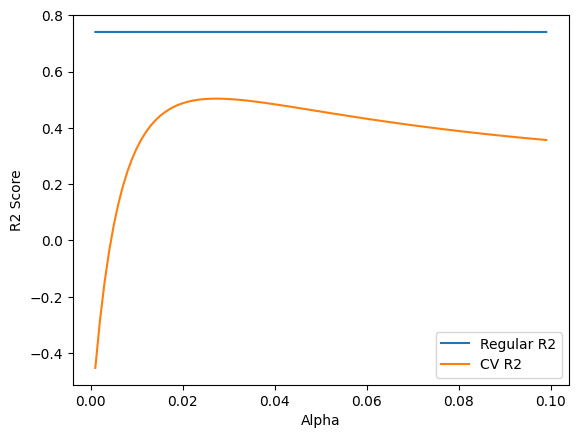

alpha1: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889, MAE: 326.823039009241, RMSE: 425.7005754359298
alpha2: 0.027, R2 Score: 0.7407013550635286, CV R2 Score: 0.5037055325847374, MAE: 326.90490921035286, RMSE: 425.7140022718935
alpha3: 0.083, R2 Score: 0.7405967186465152, CV R2 Score: 0.3830985134182592, MAE: 326.6115660730521, RMSE: 425.79988913583645
alpha4: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889, MAE: 326.823039009241, RMSE: 425.7005754359298


In [26]:
prettyPrintReg(graphRegressionValues(ridgeRegression, scaled_data_array, 1, 100, 1, 1000))

In [27]:
ridge_main = ridgeRegression(0.027, **scaled_data_array)["Model"]

In [28]:
prettyPrint(ridgeRegression(0.027, **scaled_data_array))

            Model: 		Ridge(alpha=0.027)
            R2 Score: 		0.7407013550635286
            CV R2 Score: 	0.5037055325847374
            MAE: 		326.90490921035286
            RMSE: 		425.7140022718935


/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.945e+05, tolerance: 2.063e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.472e+06, tolerance: 2.509e+04
  model = cd_fast.enet_coordinate_descent(
/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: O

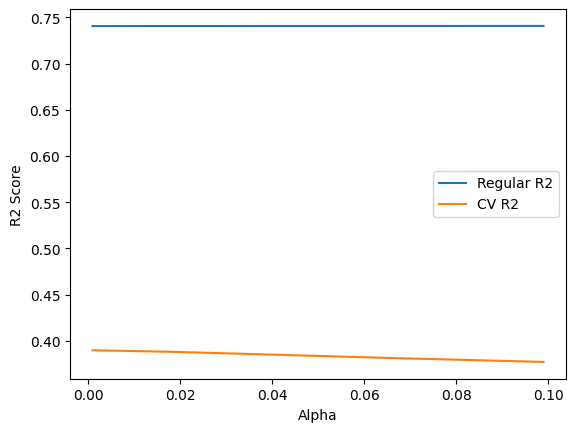

alpha1: 0.099, R2 Score: 0.7407390802818031, CV R2 Score: 0.37720597426884417, MAE: 327.0722370865005, RMSE: 425.68303269654064
alpha2: 0.001, R2 Score: 0.7405787544873326, CV R2 Score: 0.3898195048380956, MAE: 327.2863110430081, RMSE: 425.8146325972989
alpha3: 0.099, R2 Score: 0.7407390802818031, CV R2 Score: 0.37720597426884417, MAE: 327.0722370865005, RMSE: 425.68303269654064
alpha4: 0.099, R2 Score: 0.7407390802818031, CV R2 Score: 0.37720597426884417, MAE: 327.0722370865005, RMSE: 425.68303269654064


In [29]:
prettyPrintReg(graphRegressionValues(lassoRegression, scaled_data_array, 1, 100, 1, 1000))


## Remove Overfitting

Both results point towards overfitting.
Now I will attempt to remove some columns

In [30]:
scaled_data.dtypes

TotalSteps                  float64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes           float64
FairlyActiveMinutes         float64
LightlyActiveMinutes        float64
SedentaryMinutes            float64
Calories                      int64
dtype: object

In [31]:
scaled_data.describe()

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,4.570000e+02,4.570000e+02,4.570000e+02,457.000000,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,457.000000,457.000000
mean,-6.219192e-17,1.554798e-17,-7.773991e-17,0.000000,1.243838e-16,3.886995e-17,-3.109596e-17,4.664394e-17,7.773991e-17,-2.137847e-17,-1.943498e-18,0.000000,2189.452954
std,1.001096e+00,1.001096e+00,1.001096e+00,1.001096,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096e+00,1.001096,815.484523
min,-1.213994e+00,-1.143692e+00,-1.134289e+00,-0.211514,-4.753180e-01,-5.766193e-01,-1.293110e+00,-2.245612e-01,-5.754502e-01,-3.613598e-01,-1.393199e+00,-2.861355,0.000000
25%,-8.453392e-01,-7.979007e-01,-8.193347e-01,-0.211514,-4.753180e-01,-5.766193e-01,-9.038613e-01,-2.245612e-01,-5.754502e-01,-3.613598e-01,-8.689165e-01,-0.793941,1776.000000
50%,-1.039506e-01,-1.406519e-01,-1.279123e-01,-0.211514,-4.753180e-01,-5.525254e-01,1.780842e-02,-2.245612e-01,-5.754502e-01,-3.337118e-01,8.953744e-02,0.183328,2062.000000
75%,6.771221e-01,6.122412e-01,6.151822e-01,-0.211514,5.196463e-02,2.305265e-01,7.023495e-01,-2.245612e-01,2.899597e-01,8.100800e-02,7.121229e-01,0.860584,2667.000000
max,4.070486e+00,5.607823e+00,5.639682e+00,7.718511,8.347610e+00,7.133430e+00,4.304020e+00,1.157135e+01,6.417062e+00,1.788631e+01,4.504979e+00,1.320999,4562.000000


TotalSteps                 -2355.119445
VeryActiveDistance         -1451.198970
LightActiveDistance         -541.699762
ModeratelyActiveDistance    -279.642450
LoggedActivitiesDistance    -101.451328
SedentaryActiveDistance       -2.075316
TrackerDistance                7.219253
SedentaryMinutes             220.749508
FairlyActiveMinutes          223.504171
LightlyActiveMinutes         245.286655
VeryActiveMinutes            783.605307
TotalDistance               3843.212379
dtype: float64


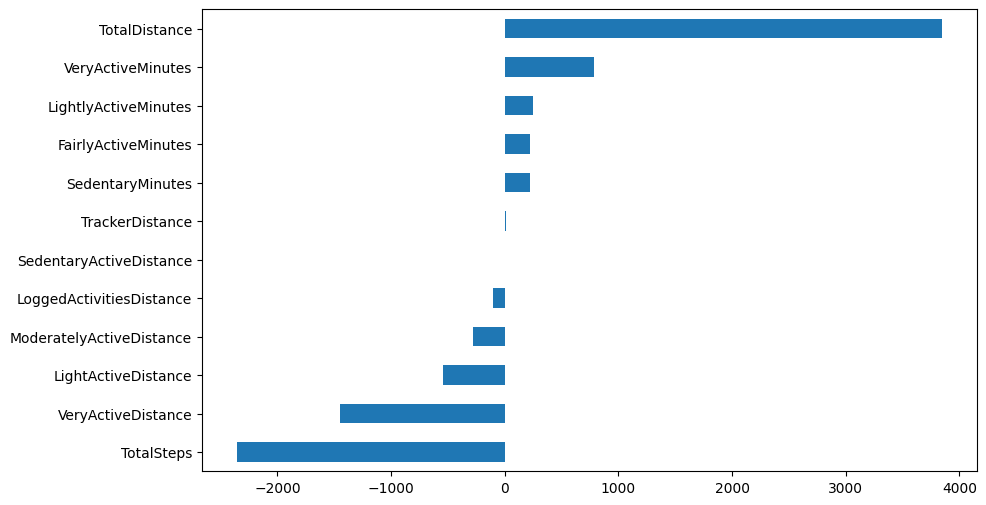

In [32]:
coefs = pd.Series(ridge_main.coef_, index=scaled_data_array["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

We observe that the coefficients for `SedentaryActiveDistance` is extremely small, hence that can be removed.

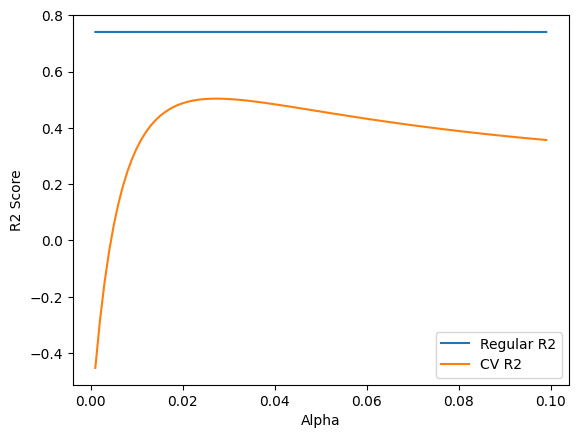

alpha1: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889, MAE: 326.823039009241, RMSE: 425.7005754359298
alpha2: 0.027, R2 Score: 0.7407013550635286, CV R2 Score: 0.5037055325847374, MAE: 326.90490921035286, RMSE: 425.7140022718935
alpha3: 0.083, R2 Score: 0.7405967186465152, CV R2 Score: 0.3830985134182592, MAE: 326.6115660730521, RMSE: 425.79988913583645
alpha4: 0.042, R2 Score: 0.7407177111403742, CV R2 Score: 0.4786640492489889, MAE: 326.823039009241, RMSE: 425.7005754359298


In [33]:
values = graphRegressionValues(ridgeRegression, scaled_data_array, 1, 100, 1, 1000)
alpha1 = values["alpha2"]
prettyPrintReg(values)


## Removing `SedentaryActiveDistance`

In [34]:
data_filtered_1 = getData(data, scaled=True, dropped_cols=["SedentaryActiveDistance"])
filtered_data_array_1 = splitData(data=data_filtered_1, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


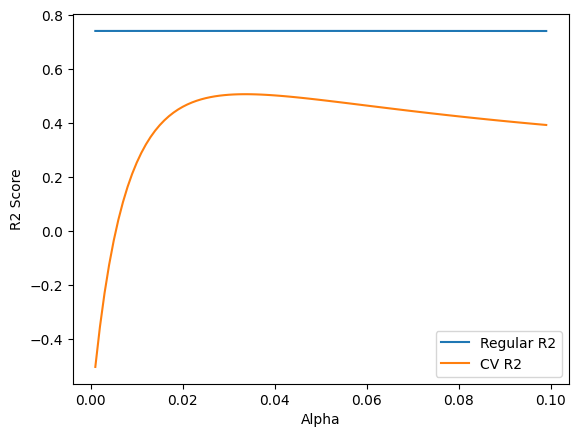

alpha1: 0.035, R2 Score: 0.7410765410310283, CV R2 Score: 0.5064691002855362, MAE: 326.5556437707768, RMSE: 425.4059024394612
alpha2: 0.034, R2 Score: 0.7410764005944699, CV R2 Score: 0.5067019991285944, MAE: 326.5605072507033, RMSE: 425.4060178066299
alpha3: 0.08, R2 Score: 0.7409330335418689, CV R2 Score: 0.4245687653981835, MAE: 326.35025171526456, RMSE: 425.5237760312859
alpha4: 0.035, R2 Score: 0.7410765410310283, CV R2 Score: 0.5064691002855362, MAE: 326.5556437707768, RMSE: 425.4059024394612


In [35]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_1, 1, 100, 1, 1000))

In [36]:
ridge_filtered_1 = ridgeRegression(0.034, **filtered_data_array_1)["Model"]
prettyPrint(ridgeRegression(0.034, **filtered_data_array_1))

            Model: 		Ridge(alpha=0.034)
            R2 Score: 		0.7410764005944699
            CV R2 Score: 	0.5067019991285944
            MAE: 		326.5605072507033
            RMSE: 		425.4060178066299


TotalSteps                 -2344.041914
VeryActiveDistance         -1445.732205
LightActiveDistance         -538.853202
ModeratelyActiveDistance    -278.704145
LoggedActivitiesDistance    -100.202971
TrackerDistance               19.217730
SedentaryMinutes             220.623232
FairlyActiveMinutes          223.225758
LightlyActiveMinutes         244.459415
VeryActiveMinutes            781.571476
TotalDistance               3814.922578
dtype: float64


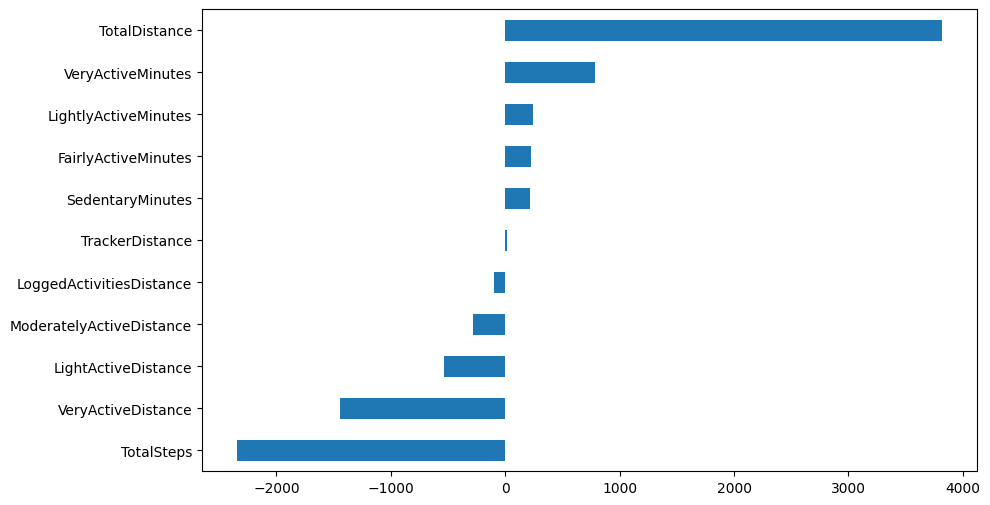

In [37]:
coefs = pd.Series(ridge_filtered_1.coef_, index=filtered_data_array_1["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

### Let us see what is the difference between `TotalDistance` and `TrackerDistance`

In [38]:
(data.TotalDistance - data.TrackerDistance).sort_values()

215   -0.57
289    0.00
302    0.00
301    0.00
300    0.00
       ... 
361    1.36
142    1.61
335    2.03
139    3.22
338    6.73
Length: 457, dtype: float64

In [39]:
data.TotalDistance.describe()

count    457.000000
mean       4.663523
std        4.082072
min        0.000000
25%        1.410000
50%        4.090000
75%        7.160000
max       27.530001
Name: TotalDistance, dtype: float64

In [40]:
(data.TotalDistance - data.TrackerDistance).describe()

count    457.000000
mean       0.053676
std        0.402765
min       -0.570000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.730000
dtype: float64

In [41]:
len(main_data.Id[data.TotalDistance - data.TrackerDistance != 0])

16

In [42]:
(data.Calories[data.TotalDistance - data.TrackerDistance != 0])

139    2881
142    1144
215    2259
335    2224
338    2442
359    2170
360    2244
361    2188
364    2188
366    2573
369    2886
370    2676
371    2811
372    2840
373    2871
377    1023
Name: Calories, dtype: int64

In [43]:
(data.TrackerDistance[data.TotalDistance - data.TrackerDistance != 0]) - (data.TotalDistance[data.TotalDistance - data.TrackerDistance != 0])

139   -3.22
142   -1.61
215    0.57
335   -2.03
338   -6.73
359   -0.61
360   -0.78
361   -1.36
364   -0.92
366   -1.25
369   -1.19
370   -1.06
371   -1.18
372   -1.15
373   -1.20
377   -0.81
dtype: float64

In [44]:
len(data)

457

Since 16/457 is a very small ratio, and the difference is small mostly we will drop one of these columns.

## Working With Distances

### Dropping TotalDistance
Since `TotalDistance` is a high-weight column, we expect performance to drop significantly.

In [45]:
data_filtered_2 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance","TotalDistance"])
filtered_data_array_2 = splitData(data=data_filtered_2, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


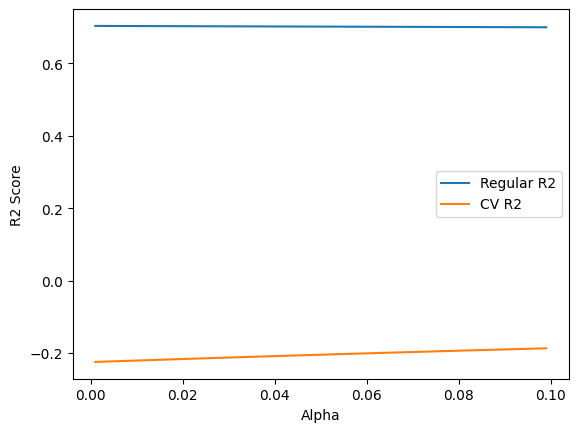

alpha1: 0.001, R2 Score: 0.7034491287192832, CV R2 Score: -0.22480277627143316, MAE: 361.18573493268093, RMSE: 455.2683018099354
alpha2: 0.099, R2 Score: 0.6997306977489304, CV R2 Score: -0.18720319497602392, MAE: 363.57987948649446, RMSE: 458.1136989920475
alpha3: 0.001, R2 Score: 0.7034491287192832, CV R2 Score: -0.22480277627143316, MAE: 361.18573493268093, RMSE: 455.2683018099354
alpha4: 0.001, R2 Score: 0.7034491287192832, CV R2 Score: -0.22480277627143316, MAE: 361.18573493268093, RMSE: 455.2683018099354


In [46]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2, 1, 100, 1, 1000))

### Dropping TrackerDistance
Since `TrackerDistance` is a very-low-weight column, we do not expect performance to drop significantly, and possibly, improve.

In [47]:
data_filtered_2 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])
filtered_data_array_2 = splitData(data=data_filtered_2, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


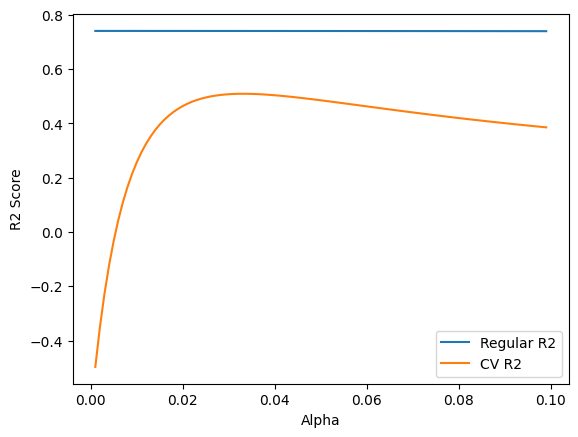

alpha1: 0.001, R2 Score: 0.7411737149754727, CV R2 Score: -0.49711491735175173, MAE: 326.8594705050815, RMSE: 425.32606755506345
alpha2: 0.033, R2 Score: 0.7410072376045951, CV R2 Score: 0.5095490981155818, MAE: 326.5937404659086, RMSE: 425.4628306804407
alpha3: 0.078, R2 Score: 0.74053491508224, CV R2 Score: 0.4240639569185303, MAE: 326.5207206750407, RMSE: 425.8506101278833
alpha4: 0.001, R2 Score: 0.7411737149754727, CV R2 Score: -0.49711491735175173, MAE: 326.8594705050815, RMSE: 425.32606755506345


In [48]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2, 1, 100, 1, 1000))

In [49]:
ridge_filtered_2 = ridgeRegression(0.033, **filtered_data_array_2)["Model"]
prettyPrint(ridgeRegression(0.033, **filtered_data_array_2))

            Model: 		Ridge(alpha=0.033)
            R2 Score: 		0.7410072376045951
            CV R2 Score: 	0.5095490981155818
            MAE: 		326.5937404659086
            RMSE: 		425.4628306804407


TotalSteps                 -2345.241372
VeryActiveDistance         -1446.481797
LightActiveDistance         -538.742807
ModeratelyActiveDistance    -278.924828
LoggedActivitiesDistance    -101.793497
SedentaryMinutes             220.518850
FairlyActiveMinutes          223.649554
LightlyActiveMinutes         243.974816
VeryActiveMinutes            782.264062
TotalDistance               3835.846780
dtype: float64


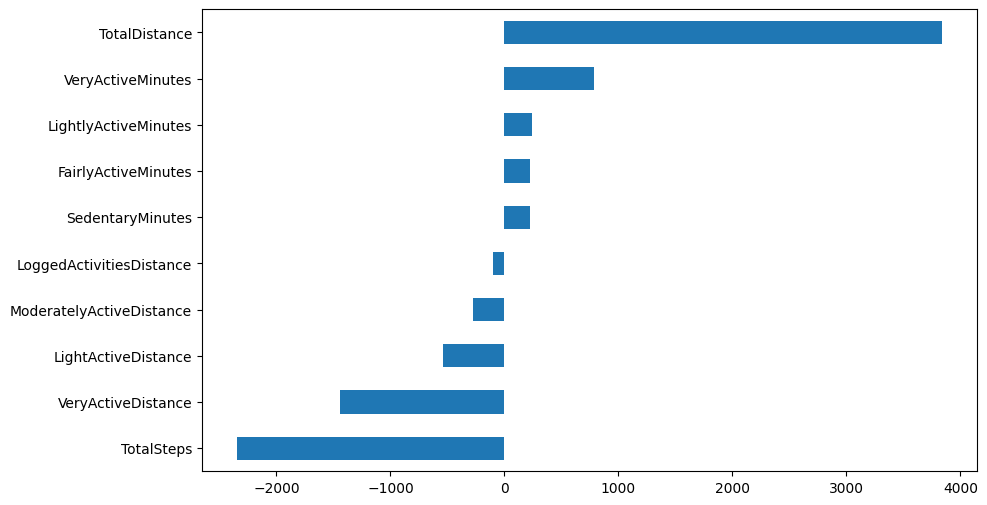

In [50]:
coefs = pd.Series(ridge_filtered_2.coef_, index=filtered_data_array_2["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Zero Columns Analysis

When we observe the columns with a lot of zero values, we find that dropping them is significant, hence we canno drop them.

In [51]:
data.describe()

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,6546.562363,4.663523,4.609847,0.179427,1.180897,0.478643,2.890197,0.001904,16.623632,13.070022,170.070022,995.282276,2189.452954
std,5398.493064,4.082072,4.068540,0.849232,2.487159,0.830995,2.237523,0.008487,28.919704,36.208635,122.205372,337.021404,815.484523
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000
25%,1988.000000,1.410000,1.280000,0.000000,0.000000,0.000000,0.870000,0.000000,0.000000,0.000000,64.000000,728.000000,1776.000000
50%,5986.000000,4.090000,4.090000,0.000000,0.000000,0.020000,2.930000,0.000000,0.000000,1.000000,181.000000,1057.000000,2062.000000
75%,10198.000000,7.160000,7.110000,0.000000,1.310000,0.670000,4.460000,0.000000,25.000000,16.000000,257.000000,1285.000000,2667.000000
max,28497.000000,27.530001,27.530001,6.727057,21.920000,6.400000,12.510000,0.100000,202.000000,660.000000,720.000000,1440.000000,4562.000000


In [52]:
data.dtypes

TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object

## Dropping SedenteryMinutes

In [53]:
data_filtered_2_1 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "VeryActiveMinutes"])
filtered_data_array_2_1 = splitData(data=data_filtered_2_1, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


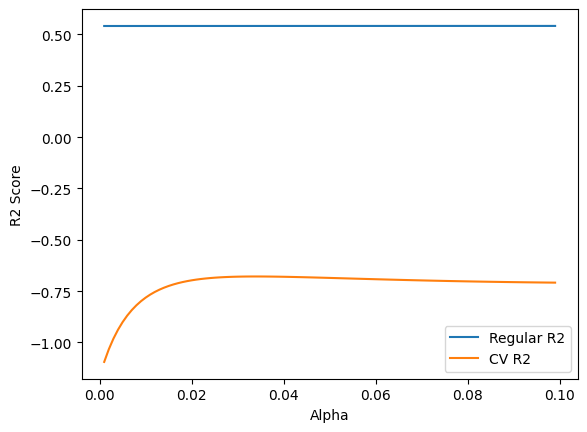

alpha1: 0.099, R2 Score: 0.541625589506848, CV R2 Score: -0.7086506635943282, MAE: 422.24344614516525, RMSE: 566.0150689615549
alpha2: 0.034, R2 Score: 0.5414423041063606, CV R2 Score: -0.6786661573644912, MAE: 421.4382022444279, RMSE: 566.1282209260917
alpha3: 0.001, R2 Score: 0.5412666742407863, CV R2 Score: -1.0947853177223013, MAE: 421.00961567741797, RMSE: 566.2366255015685
alpha4: 0.099, R2 Score: 0.541625589506848, CV R2 Score: -0.7086506635943282, MAE: 422.24344614516525, RMSE: 566.0150689615549


In [54]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_2_1, 1, 100, 1, 1000))

In [55]:
ridge_filtered_2_1 = ridgeRegression(0.04, **filtered_data_array_2_1)["Model"]
prettyPrint(ridgeRegression(0.04, **filtered_data_array_2_1))

            Model: 		Ridge(alpha=0.04)
            R2 Score: 		0.541467947406948
            CV R2 Score: 	-0.6800968876903675
            MAE: 		421.51465732982655
            RMSE: 		566.1123912941446


TotalSteps                 -2345.241372
VeryActiveDistance         -1446.481797
LightActiveDistance         -538.742807
ModeratelyActiveDistance    -278.924828
LoggedActivitiesDistance    -101.793497
SedentaryMinutes             220.518850
FairlyActiveMinutes          223.649554
LightlyActiveMinutes         243.974816
VeryActiveMinutes            782.264062
TotalDistance               3835.846780
dtype: float64


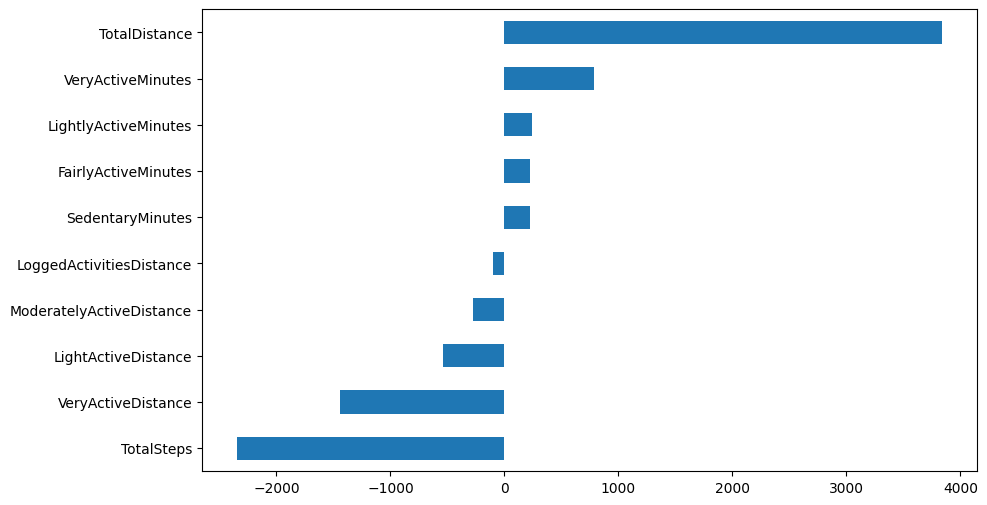

In [56]:
coefs = pd.Series(ridge_filtered_2.coef_, index=filtered_data_array_2["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## StepSize Analysis

In [57]:
(main_data.TotalDistance / main_data.TotalSteps).describe()


count    396.000000
mean       0.000701
std        0.000097
min        0.000000
25%        0.000661
50%        0.000683
75%        0.000739
max        0.001429
dtype: float64

In [58]:
test_df = data[data.TotalSteps != 0]
test_df.Calories.describe()

count     396.000000
mean     2284.098485
std       787.306771
min        50.000000
25%      1814.750000
50%      2182.500000
75%      2787.000000
max      4526.000000
Name: Calories, dtype: float64

In [59]:
test_df.SedentaryMinutes.describe()

count     396.000000
mean      942.250000
std       311.548774
min        32.000000
25%       709.500000
50%       940.000000
75%      1186.000000
max      1440.000000
Name: SedentaryMinutes, dtype: float64

In [60]:
print(*test_df.SedentaryMinutes.sort_values())

32 61 75 99 146 161 187 207 209 223 243 253 321 356 388 400 405 407 413 463 466 471 475 491 507 528 531 550 551 551 552 555 568 569 570 578 578 583 588 589 593 595 598 599 599 600 601 601 602 604 605 605 609 613 614 615 617 620 621 621 636 636 638 638 641 644 654 654 655 657 658 663 665 668 670 672 673 675 678 679 683 685 686 688 689 692 694 695 695 696 697 697 700 700 700 702 702 708 708 710 711 717 719 719 720 720 721 721 727 728 729 731 732 735 736 737 738 738 739 739 741 741 742 745 745 746 748 748 748 752 754 755 756 756 757 757 758 759 759 760 763 767 770 770 770 771 772 776 777 782 786 788 789 795 795 797 804 804 805 807 808 809 810 811 813 814 815 820 829 838 842 842 842 843 854 855 855 858 860 866 866 868 872 874 882 886 888 888 894 898 904 909 912 912 918 920 938 939 941 970 982 986 990 1002 1002 1005 1011 1015 1018 1019 1020 1030 1030 1038 1040 1052 1052 1054 1055 1055 1055 1057 1058 1058 1060 1063 1063 1066 1069 1073 1074 1074 1075 1077 1078 1079 1080 1082 1085 1092 1093 10

## Adding StepSize

### Dropping Both "TotalDistance", "TotalSteps"

In [61]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


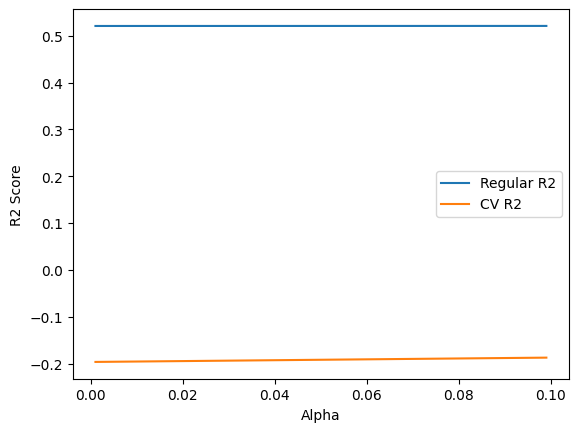

alpha1: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187, MAE: 473.7034595713511, RMSE: 578.6720259968793
alpha2: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187, MAE: 473.7034595713511, RMSE: 578.6720259968793
alpha3: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187, MAE: 473.7034595713511, RMSE: 578.6720259968793
alpha4: 0.099, R2 Score: 0.5208964883951783, CV R2 Score: -0.18712973581346187, MAE: 473.7034595713511, RMSE: 578.6720259968793


In [62]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping "TotalSteps"

In [63]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalSteps"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


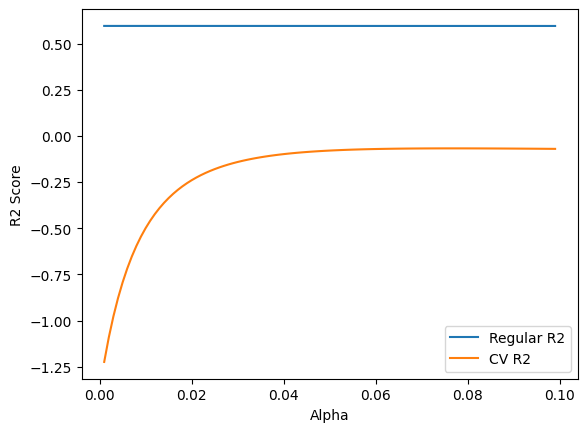

alpha1: 0.001, R2 Score: 0.5953797152918339, CV R2 Score: -1.2236910359802167, MAE: 434.9122078180692, RMSE: 531.7918006844538
alpha2: 0.077, R2 Score: 0.5952115383012653, CV R2 Score: -0.06755631694141273, MAE: 434.8600000876844, RMSE: 531.9023065793864
alpha3: 0.099, R2 Score: 0.5951602125677364, CV R2 Score: -0.07024556730468087, MAE: 434.8448429967419, RMSE: 531.9360271684033
alpha4: 0.001, R2 Score: 0.5953797152918339, CV R2 Score: -1.2236910359802167, MAE: 434.9122078180692, RMSE: 531.7918006844538


In [64]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping "TotalDistance"

In [65]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "TotalDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


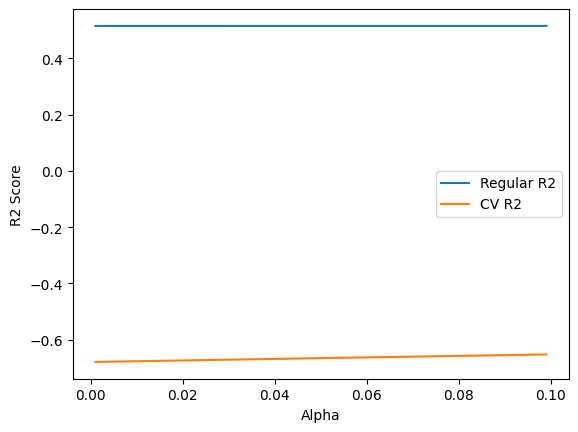

alpha1: 0.099, R2 Score: 0.5149024348431761, CV R2 Score: -0.6523803551879732, MAE: 480.5761399039486, RMSE: 582.2806507524338
alpha2: 0.099, R2 Score: 0.5149024348431761, CV R2 Score: -0.6523803551879732, MAE: 480.5761399039486, RMSE: 582.2806507524338
alpha3: 0.099, R2 Score: 0.5149024348431761, CV R2 Score: -0.6523803551879732, MAE: 480.5761399039486, RMSE: 582.2806507524338
alpha4: 0.099, R2 Score: 0.5149024348431761, CV R2 Score: -0.6523803551879732, MAE: 480.5761399039486, RMSE: 582.2806507524338


In [66]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

### Dropping None

In [67]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data_filtered_3 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])

# data = data.drop(columns=["StepSize"])

filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


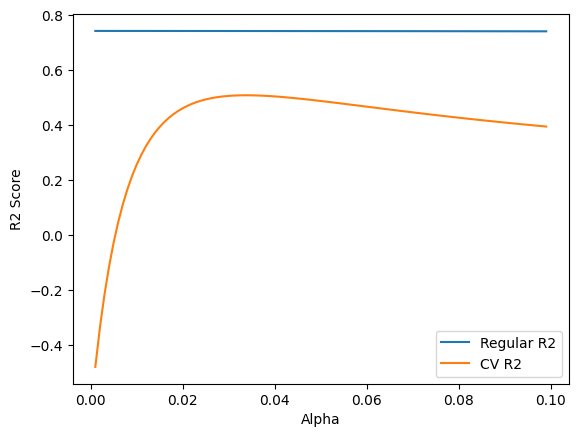

alpha1: 0.001, R2 Score: 0.7424096000976388, CV R2 Score: -0.4797763904110903, MAE: 329.53960145075945, RMSE: 424.30939500979895
alpha2: 0.034, R2 Score: 0.7420536718876126, CV R2 Score: 0.5083514615465516, MAE: 329.58072626296865, RMSE: 424.6024407713967
alpha3: 0.011, R2 Score: 0.7423176643974239, CV R2 Score: 0.2921335258886589, MAE: 329.5239410800928, RMSE: 424.38510765537075
alpha4: 0.001, R2 Score: 0.7424096000976388, CV R2 Score: -0.4797763904110903, MAE: 329.53960145075945, RMSE: 424.30939500979895


In [68]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 100, 1, 1000))

In [69]:
ridge_filtered_3 = ridgeRegression(0.034, **filtered_data_array_3)["Model"]
prettyPrint(ridgeRegression(0.034, **filtered_data_array_3))

            Model: 		Ridge(alpha=0.034)
            R2 Score: 		0.7420536718876126
            CV R2 Score: 	0.5083514615465516
            MAE: 		329.58072626296865
            RMSE: 		424.6024407713967


TotalSteps                 -2257.131957
VeryActiveDistance         -1386.740130
LightActiveDistance         -504.069309
ModeratelyActiveDistance    -269.337583
LoggedActivitiesDistance    -101.080883
StepSize                      81.489416
LightlyActiveMinutes         217.040331
FairlyActiveMinutes          230.535474
SedentaryMinutes             237.651999
VeryActiveMinutes            769.586209
TotalDistance               3655.430870
dtype: float64


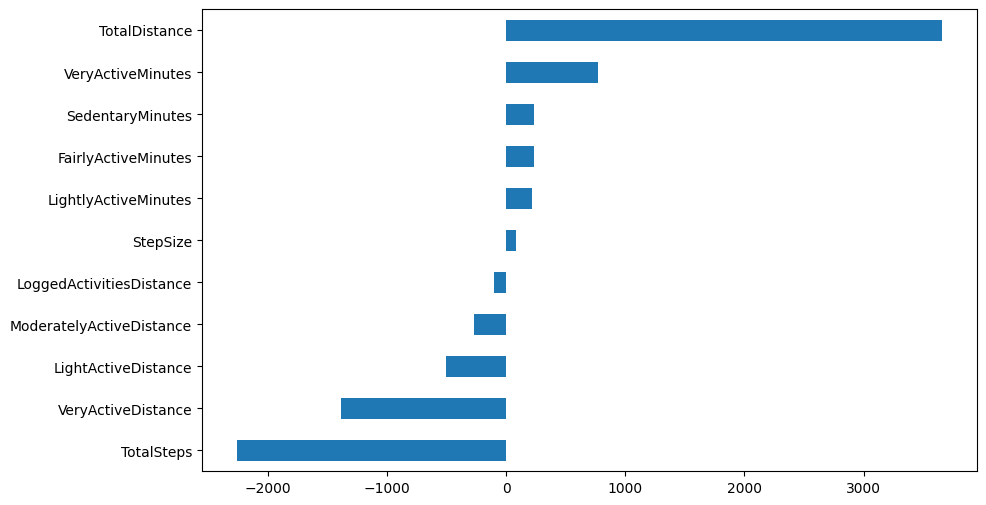

In [70]:
coefs = pd.Series(ridge_filtered_3.coef_, index=filtered_data_array_3["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Working with "VeryActiveMinutes", "FairlyActiveMinutes", "VeryActiveDistance" and "ModeratelyActiveDistance"

### Dropping "VeryActiveMinutes", "FairlyActiveMinutes"

In [71]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "FairlyActiveMinutes", "VeryActiveMinutes"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


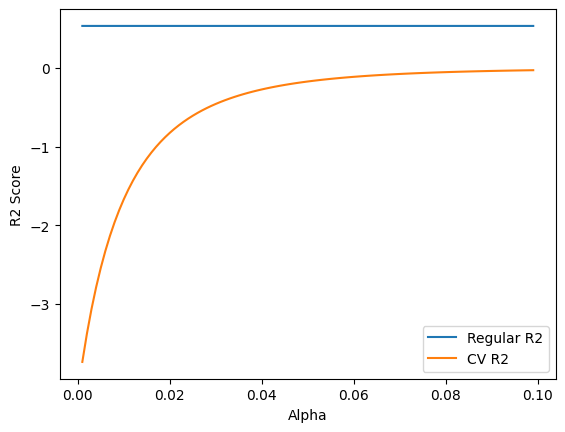

alpha1: 0.051, R2 Score: 0.5316440766074271, CV R2 Score: -0.1665047406134151, MAE: 425.5723565360763, RMSE: 572.1446218186162
alpha2: 0.099, R2 Score: 0.5315973963516047, CV R2 Score: -0.030631019237564772, MAE: 426.2763504380218, RMSE: 572.1731334595833
alpha3: 0.001, R2 Score: 0.5315883214216368, CV R2 Score: -3.7348417928278734, MAE: 424.8025096737019, RMSE: 572.1786761336906
alpha4: 0.051, R2 Score: 0.5316440766074271, CV R2 Score: -0.1665047406134151, MAE: 425.5723565360763, RMSE: 572.1446218186162


In [72]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "VeryActiveMinutes", "ModeratelyActiveDistance"

In [73]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveMinutes"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


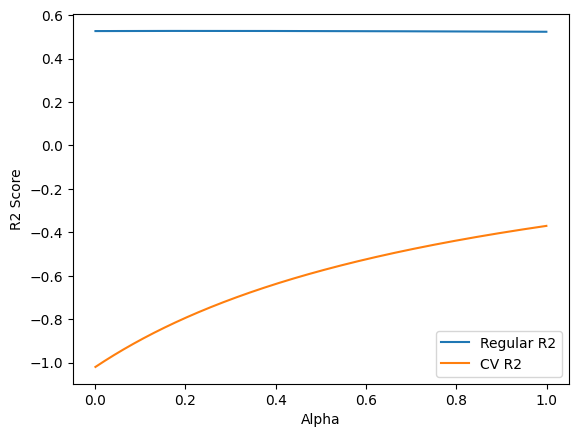

alpha1: 0.224, R2 Score: 0.5272975860505114, CV R2 Score: -0.7727881561216584, MAE: 434.74412954825704, RMSE: 574.7933319860218
alpha2: 0.999, R2 Score: 0.5234405931726758, CV R2 Score: -0.3707195050644108, MAE: 441.1111843568975, RMSE: 577.1335673599411
alpha3: 0.001, R2 Score: 0.5266042050377673, CV R2 Score: -1.0202879224705859, MAE: 433.9367968087722, RMSE: 575.2147437717095
alpha4: 0.224, R2 Score: 0.5272975860505114, CV R2 Score: -0.7727881561216584, MAE: 434.74412954825704, RMSE: 574.7933319860218


In [74]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 1000, 1, 1000))

### Dropping "VeryActiveDistance", "ModeratelyActiveDistance"

In [75]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


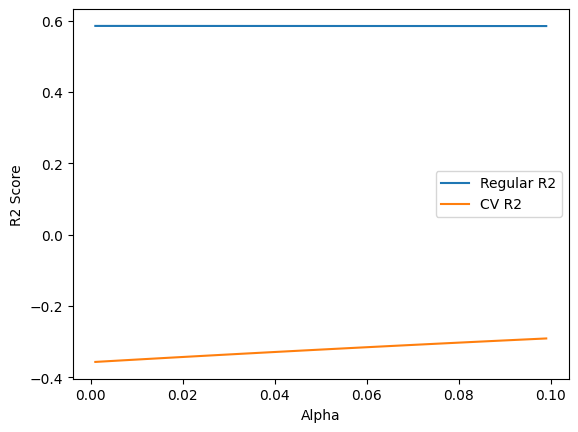

alpha1: 0.001, R2 Score: 0.5854961035630157, CV R2 Score: -0.35734250012294433, MAE: 425.6900589181352, RMSE: 538.2476222787235
alpha2: 0.099, R2 Score: 0.5851281762255249, CV R2 Score: -0.29149780004289577, MAE: 426.33951972405436, RMSE: 538.4864524681924
alpha3: 0.001, R2 Score: 0.5854961035630157, CV R2 Score: -0.35734250012294433, MAE: 425.6900589181352, RMSE: 538.2476222787235
alpha4: 0.001, R2 Score: 0.5854961035630157, CV R2 Score: -0.35734250012294433, MAE: 425.6900589181352, RMSE: 538.2476222787235


In [76]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "VeryActiveDistance", "FairlyActiveMinutes"

In [77]:
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "FairlyActiveMinutes", "VeryActiveDistance"])
filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


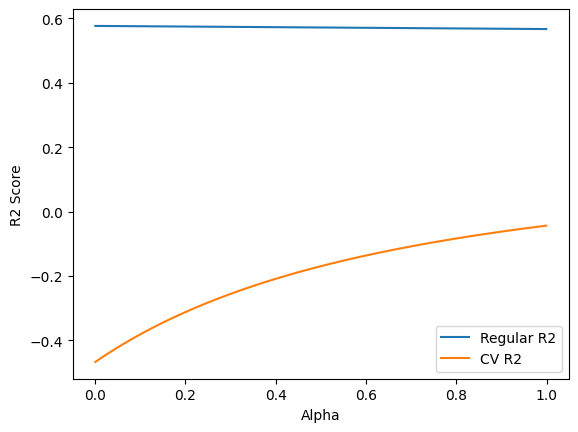

alpha1: 0.001, R2 Score: 0.5764466161928992, CV R2 Score: -0.4667856768015045, MAE: 426.5785540317303, RMSE: 544.091434741509
alpha2: 0.999, R2 Score: 0.5667372616626982, CV R2 Score: -0.04369359634461305, MAE: 435.53901224695005, RMSE: 550.2923576104803
alpha3: 0.001, R2 Score: 0.5764466161928992, CV R2 Score: -0.4667856768015045, MAE: 426.5785540317303, RMSE: 544.091434741509
alpha4: 0.001, R2 Score: 0.5764466161928992, CV R2 Score: -0.4667856768015045, MAE: 426.5785540317303, RMSE: 544.091434741509


In [78]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 1000, 1, 1000))

## 61 abnormal rows

In [79]:
data[data.TotalSteps == 0].describe()

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,StepSize
count,61.0,61.0,61.0,61.000000,61.0,61.0,61.0,61.0,61.000000,61.000000,61.0,61.000000,61.000000,61.0
mean,0.0,0.0,0.0,0.079148,0.0,0.0,0.0,0.0,0.868852,10.819672,0.0,1339.557377,1575.032787,0.0
std,0.0,0.0,0.0,0.618166,0.0,0.0,0.0,0.0,4.903996,84.504341,0.0,291.848564,728.352043,0.0
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,198.000000,0.000000,0.0
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1347.000000,0.0
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1776.000000,0.0
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1440.000000,1878.000000,0.0
max,0.0,0.0,0.0,4.828032,0.0,0.0,0.0,0.0,33.000000,660.000000,0.0,1440.000000,4562.000000,0.0


In [80]:
data

,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,StepSize
0,11004,7.110000,7.110000,0.0,2.57,0.46,4.07,0.00,33,12,205,804,1819,0.000646
1,17609,11.550000,11.550000,0.0,6.92,0.73,3.91,0.00,89,17,274,588,2154,0.000656
2,12736,8.530000,8.530000,0.0,4.66,0.16,3.71,0.00,56,5,268,605,1944,0.000670
3,13231,8.930000,8.930000,0.0,3.19,0.79,4.95,0.00,39,20,224,1080,1932,0.000675
4,12041,7.850000,7.850000,0.0,2.16,1.09,4.61,0.00,28,28,243,763,1886,0.000652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,23014,20.389999,20.389999,0.0,11.10,0.63,8.62,0.00,70,29,359,982,4196,0.000886
453,16470,8.070000,8.070000,0.0,0.00,0.02,8.02,0.00,90,9,289,1052,3841,0.000490
454,28497,27.530001,27.530001,0.0,21.92,1.12,4.46,0.00,128,46,211,1055,4526,0.000966
455,10622,8.060000,8.060000,0.0,1.47,0.15,6.37,0.01,18,7,225,1190,2820,0.000759


## Dropping 0 rows

In [81]:
activity_cols = data.drop(columns=["Calories", "SedentaryMinutes"]).columns
data_cleaned = data[~(data[activity_cols] == 0).all(axis=1)]

In [82]:
data_filtered_3 = getData(scaled=True, data=data_cleaned, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])
filtered_data_array_3 = splitData(data=data_filtered_3, randomState=randomState)

Train shape: (279, 12)
Test shape: (120, 12)


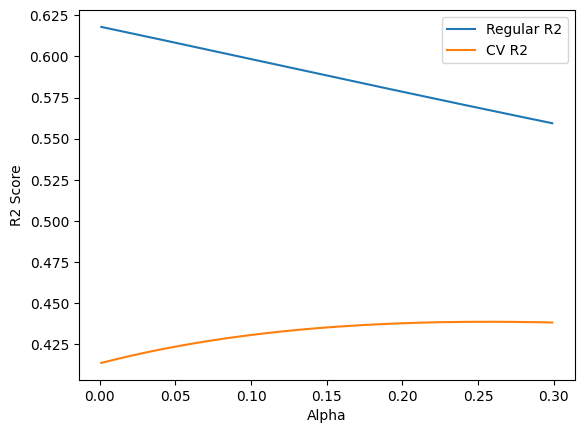

alpha1: 0.001, R2 Score: 0.6178844482210174, CV R2 Score: 0.4137528788611086, MAE: 353.5171066718007, RMSE: 462.7668829575018
alpha2: 0.257, R2 Score: 0.5673943523076537, CV R2 Score: 0.4387563858184624, MAE: 360.77455364395297, RMSE: 492.3920219849921
alpha3: 0.001, R2 Score: 0.6178844482210174, CV R2 Score: 0.4137528788611086, MAE: 353.5171066718007, RMSE: 462.7668829575018
alpha4: 0.001, R2 Score: 0.6178844482210174, CV R2 Score: 0.4137528788611086, MAE: 353.5171066718007, RMSE: 462.7668829575018


In [83]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_3, 1, 300, 1, 1000))

## Working with VeryActiveSpeed

### Dropping Both "VeryActiveDistance", "VeryActiveMinutes"

In [84]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "VeryActiveDistance", "VeryActiveMinutes"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


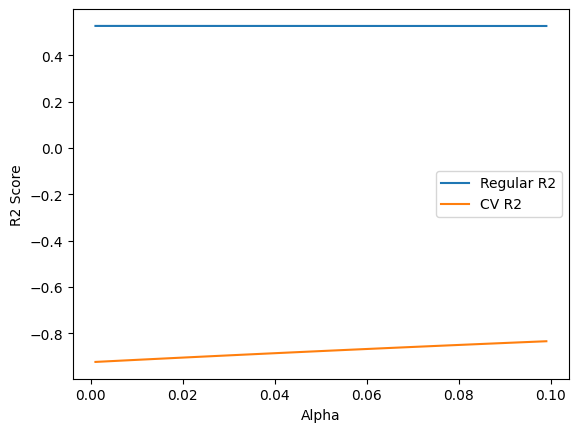

alpha1: 0.001, R2 Score: 0.526830584489538, CV R2 Score: -0.9228642238377265, MAE: 440.0668006498306, RMSE: 575.0771925186336
alpha2: 0.099, R2 Score: 0.5265448692810026, CV R2 Score: -0.8336338105099423, MAE: 440.7755775129177, RMSE: 575.2507915493404
alpha3: 0.001, R2 Score: 0.526830584489538, CV R2 Score: -0.9228642238377265, MAE: 440.0668006498306, RMSE: 575.0771925186336
alpha4: 0.001, R2 Score: 0.526830584489538, CV R2 Score: -0.9228642238377265, MAE: 440.0668006498306, RMSE: 575.0771925186336


In [85]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "VeryActiveMinutes"

In [86]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "VeryActiveMinutes"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


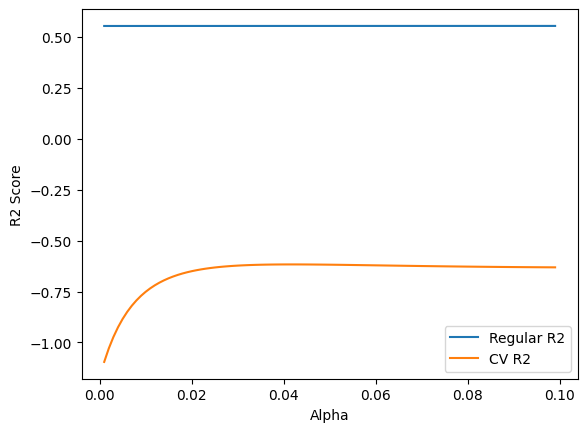

alpha1: 0.099, R2 Score: 0.5549157299822285, CV R2 Score: -0.6309839256657115, MAE: 417.9636117789075, RMSE: 557.7491720318206
alpha2: 0.042, R2 Score: 0.5548133049338648, CV R2 Score: -0.6166541807208363, MAE: 417.33806846690806, RMSE: 557.8133443734755
alpha3: 0.001, R2 Score: 0.5546481065900012, CV R2 Score: -1.095571686874753, MAE: 416.86723518894723, RMSE: 557.916830500331
alpha4: 0.099, R2 Score: 0.5549157299822285, CV R2 Score: -0.6309839256657115, MAE: 417.9636117789075, RMSE: 557.7491720318206


In [87]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping Both "VeryActiveDistance"

In [88]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "VeryActiveDistance"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


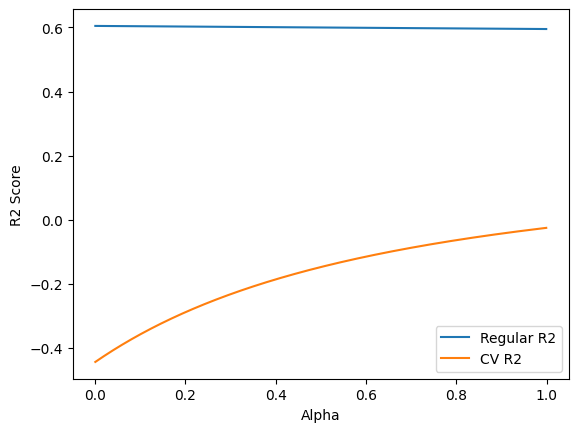

alpha1: 0.001, R2 Score: 0.6048090662282664, CV R2 Score: -0.4444914527531057, MAE: 411.1867863823105, RMSE: 525.5587822271347
alpha2: 0.999, R2 Score: 0.5951189758767348, CV R2 Score: -0.025866829789174695, MAE: 420.2529631771871, RMSE: 531.9631177900717
alpha3: 0.001, R2 Score: 0.6048090662282664, CV R2 Score: -0.4444914527531057, MAE: 411.1867863823105, RMSE: 525.5587822271347
alpha4: 0.001, R2 Score: 0.6048090662282664, CV R2 Score: -0.4444914527531057, MAE: 411.1867863823105, RMSE: 525.5587822271347


In [89]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 1000, 1, 1000))

### Dropping None

In [90]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
# data = data.drop(columns=["StepSize"])
# data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
# data["LessActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])

data = data.drop(columns=["VeryActiveSpeed"])
# data = data.drop(columns=["FairlyActiveSpeed"])
# data = data.drop(columns=["LessActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 13)
Test shape: (138, 13)


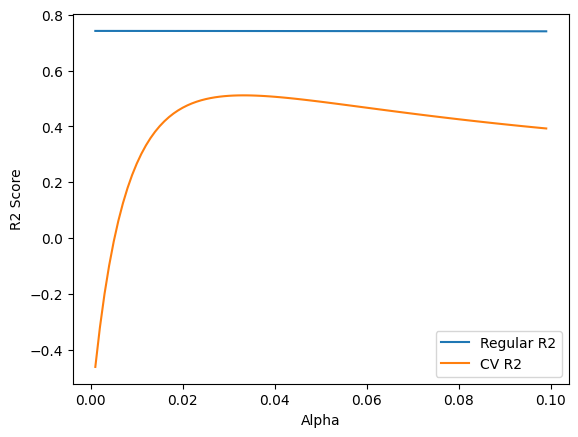

alpha1: 0.001, R2 Score: 0.742437673502014, CV R2 Score: -0.4616556409974203, MAE: 330.28752044213405, RMSE: 424.286272770384
alpha2: 0.033, R2 Score: 0.7421273895306031, CV R2 Score: 0.5115341157122659, MAE: 330.24777033470076, RMSE: 424.5417635599376
alpha3: 0.045, R2 Score: 0.7419725277418356, CV R2 Score: 0.4984392711588554, MAE: 330.2430996744879, RMSE: 424.6692207356916
alpha4: 0.001, R2 Score: 0.742437673502014, CV R2 Score: -0.4616556409974203, MAE: 330.28752044213405, RMSE: 424.286272770384


In [91]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

In [92]:
ridge_filtered_4 = ridgeRegression(alpha=0.033, **filtered_data_array_4)["Model"]
prettyPrint(ridgeRegression(alpha=0.033, **filtered_data_array_4))

            Model: 		Ridge(alpha=0.033)
            R2 Score: 		0.7421273895306031
            CV R2 Score: 	0.5115341157122659
            MAE: 		330.24777033470076
            RMSE: 		424.5417635599376


TotalSteps                 -2280.103140
VeryActiveDistance         -1404.974295
LightActiveDistance         -511.372217
ModeratelyActiveDistance    -274.643678
LoggedActivitiesDistance    -101.715914
VeryActiveSpeed               18.807472
StepSize                      79.917378
LightlyActiveMinutes         218.405682
FairlyActiveMinutes          230.793682
SedentaryMinutes             237.560686
VeryActiveMinutes            774.107688
TotalDistance               3683.242588
dtype: float64


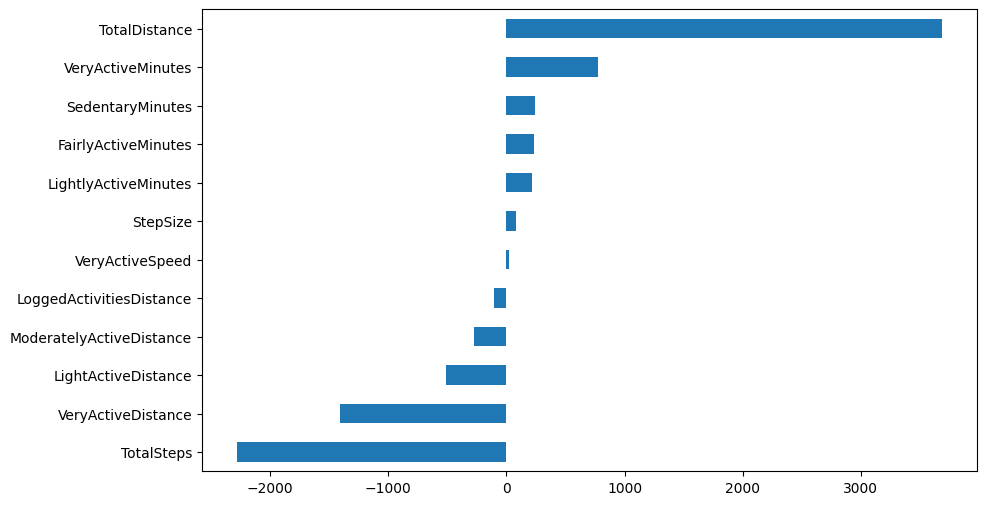

In [93]:
coefs = pd.Series(ridge_filtered_4.coef_, index=filtered_data_array_4["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Working with ModeratelyActiveSpeed

### Dropping Both "ModeratelyActiveDistance", "FairlyActiveMinutes"

In [94]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
# data = data.drop(columns=["StepSize"])
data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance", "FairlyActiveMinutes"])

data = data.drop(columns=["FairlyActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


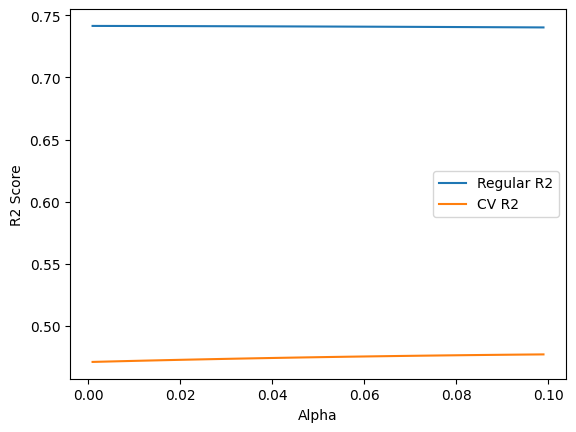

alpha1: 0.001, R2 Score: 0.7414776704012962, CV R2 Score: 0.47106934274642515, MAE: 327.06609032102034, RMSE: 425.0762510736039
alpha2: 0.099, R2 Score: 0.7402655044180761, CV R2 Score: 0.4771251923731543, MAE: 327.6545676620215, RMSE: 426.0716397311614
alpha3: 0.001, R2 Score: 0.7414776704012962, CV R2 Score: 0.47106934274642515, MAE: 327.06609032102034, RMSE: 425.0762510736039
alpha4: 0.001, R2 Score: 0.7414776704012962, CV R2 Score: 0.47106934274642515, MAE: 327.06609032102034, RMSE: 425.0762510736039


In [95]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "FairlyActiveMinutes"

In [96]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
# data = data.drop(columns=["StepSize"])
data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "FairlyActiveMinutes"])

data = data.drop(columns=["FairlyActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


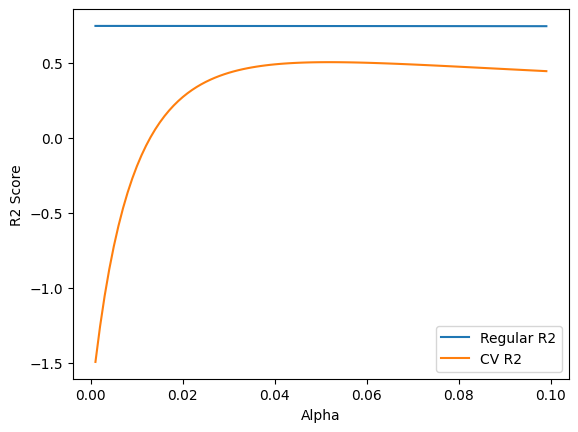

alpha1: 0.001, R2 Score: 0.743788602681501, CV R2 Score: -1.4941759735278444, MAE: 322.03729933835433, RMSE: 423.1721069622032
alpha2: 0.052, R2 Score: 0.7430084065180014, CV R2 Score: 0.5023512746476031, MAE: 322.76862647684607, RMSE: 423.81592354705583
alpha3: 0.001, R2 Score: 0.743788602681501, CV R2 Score: -1.4941759735278444, MAE: 322.03729933835433, RMSE: 423.1721069622032
alpha4: 0.001, R2 Score: 0.743788602681501, CV R2 Score: -1.4941759735278444, MAE: 322.03729933835433, RMSE: 423.1721069622032


In [97]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping Both "ModeratelyActiveDistance"

In [98]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data = data.drop(columns=["StepSize"])
data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "ModeratelyActiveDistance"])

data = data.drop(columns=["FairlyActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


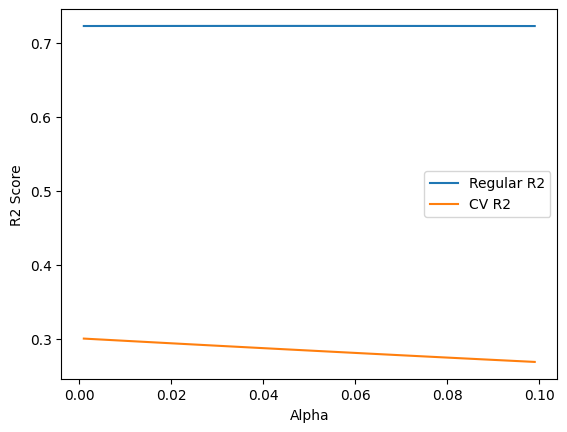

alpha1: 0.046, R2 Score: 0.7232183799192468, CV R2 Score: 0.2856579014217801, MAE: 341.23345937026863, RMSE: 439.83160658330803
alpha2: 0.001, R2 Score: 0.7230957555574185, CV R2 Score: 0.3005280742890576, MAE: 341.3513259813594, RMSE: 439.92902652341434
alpha3: 0.059, R2 Score: 0.723207980044276, CV R2 Score: 0.2814781577388044, MAE: 341.20035445039923, RMSE: 439.8398696875346
alpha4: 0.046, R2 Score: 0.7232183799192468, CV R2 Score: 0.2856579014217801, MAE: 341.23345937026863, RMSE: 439.83160658330803


In [99]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping None

In [100]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
# data = data.drop(columns=["StepSize"])
data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])

data = data.drop(columns=["FairlyActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 13)
Test shape: (138, 13)


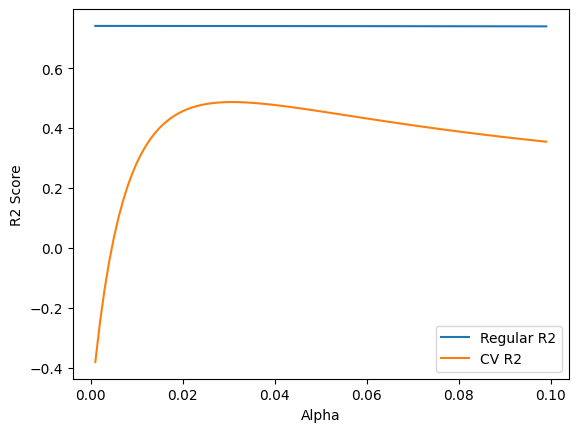

alpha1: 0.001, R2 Score: 0.7410679239915685, CV R2 Score: -0.380421154768464, MAE: 331.44318791622874, RMSE: 425.4129811896132
alpha2: 0.031, R2 Score: 0.7407477200485224, CV R2 Score: 0.48692296813029773, MAE: 331.53697852170336, RMSE: 425.67593977882734
alpha3: 0.001, R2 Score: 0.7410679239915685, CV R2 Score: -0.380421154768464, MAE: 331.44318791622874, RMSE: 425.4129811896132
alpha4: 0.001, R2 Score: 0.7410679239915685, CV R2 Score: -0.380421154768464, MAE: 331.44318791622874, RMSE: 425.4129811896132


In [101]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

In [102]:
ridge_filtered_4 = ridgeRegression(alpha=0.033, **filtered_data_array_4)["Model"]
prettyPrint(ridgeRegression(alpha=0.033, **filtered_data_array_4))

            Model: 		Ridge(alpha=0.033)
            R2 Score: 		0.7407220932850086
            CV R2 Score: 	0.48617979059552674
            MAE: 		331.54756427163414
            RMSE: 		425.69697802597375


TotalSteps                 -2288.040074
VeryActiveDistance         -1400.812577
LightActiveDistance         -518.657613
ModeratelyActiveDistance    -288.736280
LoggedActivitiesDistance    -104.973891
FairlyActiveSpeed             37.249748
StepSize                      78.468904
LightlyActiveMinutes         219.780691
FairlyActiveMinutes          233.308638
SedentaryMinutes             239.294850
VeryActiveMinutes            767.671680
TotalDistance               3694.722426
dtype: float64


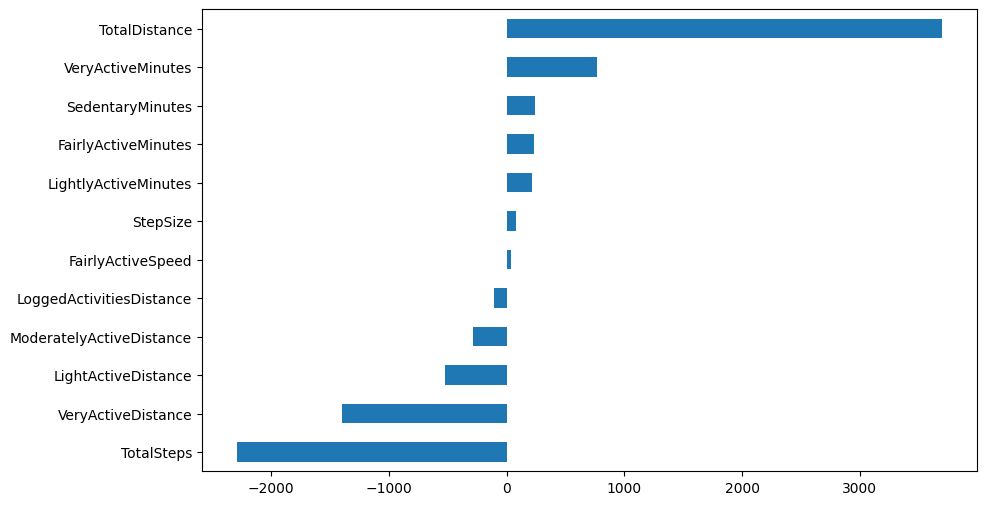

In [103]:
coefs = pd.Series(ridge_filtered_4.coef_, index=filtered_data_array_4["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

## Working with LessActiveSpeed

### Dropping Both "LightActiveDistance", "LightlyActiveMinutes"

In [104]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data = data.drop(columns=["StepSize"])
data["LessActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "LightActiveDistance", "LightlyActiveMinutes"])

data = data.drop(columns=["LessActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 10)
Test shape: (138, 10)


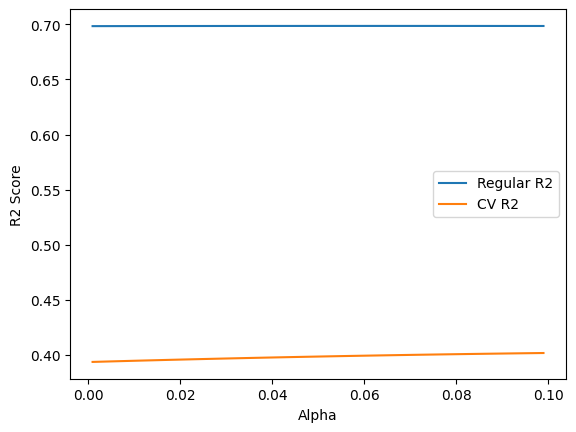

alpha1: 0.063, R2 Score: 0.6985227361732201, CV R2 Score: 0.3996721931396147, MAE: 348.5488052660204, RMSE: 459.03425314557484
alpha2: 0.099, R2 Score: 0.6984616805804129, CV R2 Score: 0.4018815570017562, MAE: 348.2833045944336, RMSE: 459.0807329186026
alpha3: 0.099, R2 Score: 0.6984616805804129, CV R2 Score: 0.4018815570017562, MAE: 348.2833045944336, RMSE: 459.0807329186026
alpha4: 0.063, R2 Score: 0.6985227361732201, CV R2 Score: 0.3996721931396147, MAE: 348.5488052660204, RMSE: 459.03425314557484


In [105]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "LightlyActiveMinutes"

In [106]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data = data.drop(columns=["StepSize"])
data["LessActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "LightlyActiveMinutes"])

data = data.drop(columns=["LessActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 11)
Test shape: (138, 11)


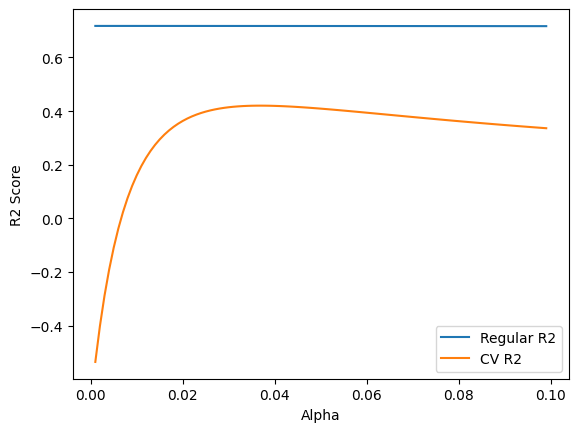

alpha1: 0.001, R2 Score: 0.7176253272354365, CV R2 Score: -0.5349149528185435, MAE: 334.5520957619446, RMSE: 444.2533195484452
alpha2: 0.037, R2 Score: 0.717433028381025, CV R2 Score: 0.4204279422365536, MAE: 333.96699335347756, RMSE: 444.40456339770213
alpha3: 0.08, R2 Score: 0.7170158863899294, CV R2 Score: 0.3624996712665991, MAE: 333.72541861481625, RMSE: 444.73247050707886
alpha4: 0.001, R2 Score: 0.7176253272354365, CV R2 Score: -0.5349149528185435, MAE: 334.5520957619446, RMSE: 444.2533195484452


In [107]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping "LightActiveDistance"

In [108]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
# data = data.drop(columns=["StepSize"])
data["LessActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance", "LightActiveDistance"])

data = data.drop(columns=["LessActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


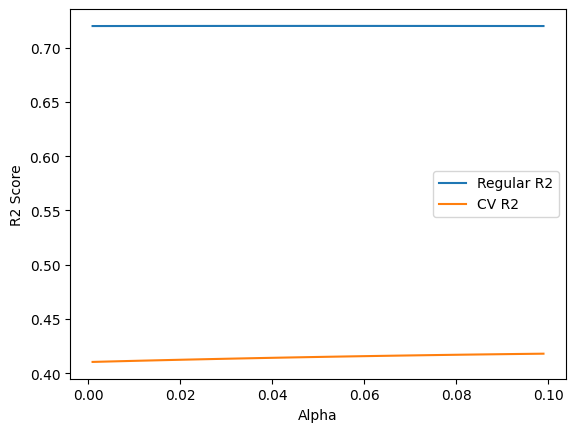

alpha1: 0.049, R2 Score: 0.7199756549762668, CV R2 Score: 0.4149941778089096, MAE: 342.6024458165561, RMSE: 442.40059902934297
alpha2: 0.099, R2 Score: 0.7198694426936278, CV R2 Score: 0.4180772908140411, MAE: 342.15197547451334, RMSE: 442.4844915970973
alpha3: 0.099, R2 Score: 0.7198694426936278, CV R2 Score: 0.4180772908140411, MAE: 342.15197547451334, RMSE: 442.4844915970973
alpha4: 0.049, R2 Score: 0.7199756549762668, CV R2 Score: 0.4149941778089096, MAE: 342.6024458165561, RMSE: 442.40059902934297


In [109]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

### Dropping None

In [110]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
data = data.drop(columns=["StepSize"])
data["LessActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
data_filtered_4 = getData(scaled=True, data=data, dropped_cols=["SedentaryActiveDistance", "TrackerDistance"])

data = data.drop(columns=["LessActiveSpeed"])

filtered_data_array_4 = splitData(data=data_filtered_4, randomState=randomState)

Train shape: (319, 12)
Test shape: (138, 12)


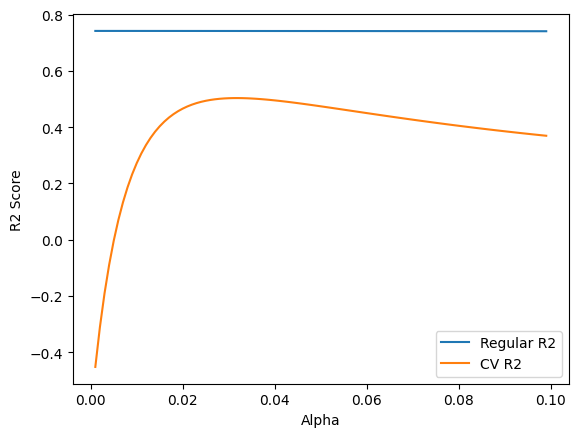

alpha1: 0.001, R2 Score: 0.7421161727950223, CV R2 Score: -0.45224908313405354, MAE: 326.4593826571809, RMSE: 424.55099664776753
alpha2: 0.032, R2 Score: 0.7419034779430491, CV R2 Score: 0.5034245796795226, MAE: 326.38092538896166, RMSE: 424.72603903195926
alpha3: 0.066, R2 Score: 0.7415193531250108, CV R2 Score: 0.43576604877442116, MAE: 326.3315977410008, RMSE: 425.0419812095305
alpha4: 0.001, R2 Score: 0.7421161727950223, CV R2 Score: -0.45224908313405354, MAE: 326.4593826571809, RMSE: 424.55099664776753


In [111]:
prettyPrintReg(graphRegressionValues(ridgeRegression, filtered_data_array_4, 1, 100, 1, 1000))

In [112]:
ridge_filtered_4 = ridgeRegression(alpha=0.033, **filtered_data_array_4)["Model"]
prettyPrint(ridgeRegression(alpha=0.033, **filtered_data_array_4))

            Model: 		Ridge(alpha=0.033)
            R2 Score: 		0.741894346926097
            CV R2 Score: 	0.5031784737666289
            MAE: 		326.37944945729043
            RMSE: 		424.73355200875415


TotalSteps                 -2341.908446
VeryActiveDistance         -1450.931213
LightActiveDistance         -561.021401
ModeratelyActiveDistance    -281.530002
LoggedActivitiesDistance    -101.792600
LessActiveSpeed               17.567757
SedentaryMinutes             223.929775
FairlyActiveMinutes          224.696503
LightlyActiveMinutes         252.604462
VeryActiveMinutes            781.109059
TotalDistance               3839.924284
dtype: float64


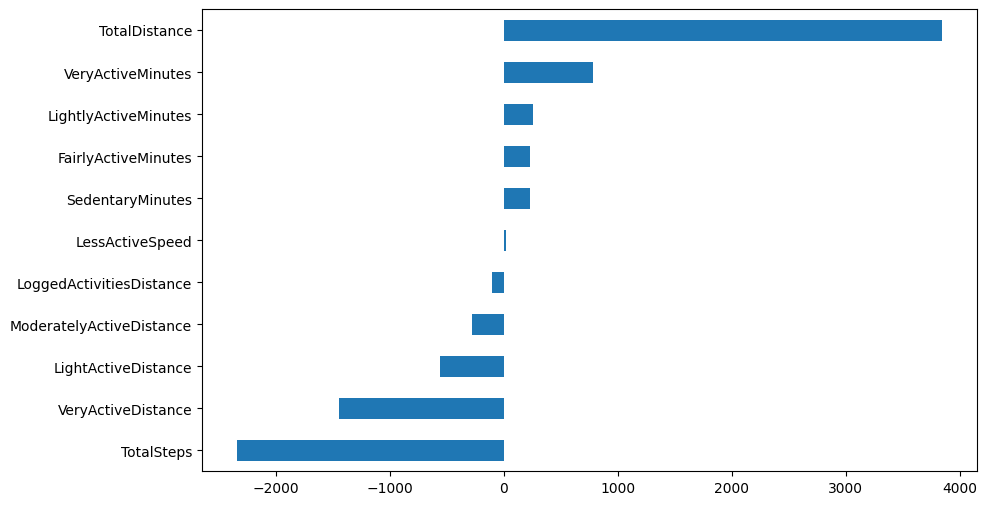

In [113]:
coefs = pd.Series(ridge_filtered_4.coef_, index=filtered_data_array_4["X"].columns)
coefs.sort_values().plot(kind='barh', figsize=(10, 6))
print(coefs.sort_values())

---

---

# 2. RandomForestRegressor

## Main Regressor

In [114]:
def randomForestRegressor(regressor, X, y, X_train, y_train, X_test, y_test, kwargs={"n_estimators": 1000, "max_depth": 10, "random_state": 42}):
    forest = regressor(**kwargs)
    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    cv_scores_full = cross_val_score(forest, X, y, cv=5, scoring='r2')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    return {
        "Model": forest,
        "R2 Score": r2_score(y_test, y_pred),
        "CV R2 Score": cv_scores_full.mean(),
        "MAE": mae,
        "RMSE": rmse
    }

In [115]:
un_scaled_data = getData(data=data, scaled=False, dropped_cols=[])
un_scaled_data_array = splitData(randomState=randomState, data=un_scaled_data)
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, kwargs={"n_estimators": 100, "max_depth": 10, "random_state": randomState}, **un_scaled_data_array))

Train shape: (319, 13)
Test shape: (138, 13)
            Model: 		RandomForestRegressor(max_depth=10, random_state=42)
            R2 Score: 		0.6585029079386573
            CV R2 Score: 	0.3753607279375024
            MAE: 		376.287639555348
            RMSE: 		488.5525858044974


In [116]:
scaled_data = getData(data=data, scaled=True, dropped_cols=[])
scaled_data_array = splitData(randomState=randomState, data=scaled_data)
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, kwargs={"n_estimators": 100, "max_depth": 10, "random_state": randomState}, **scaled_data_array))

Train shape: (319, 13)
Test shape: (138, 13)
            Model: 		RandomForestRegressor(max_depth=10, random_state=42)
            R2 Score: 		0.6583538612734494
            CV R2 Score: 	0.37590944799867254
            MAE: 		376.4868233721114
            RMSE: 		488.6591887476051


## Graph Comparison

In [117]:
def prettyPrintRegRF(array):
    print(f'num_estimators1: {array["estimators1"]}, max_depth1: {array["depth1"]}, R2 Score: {array["R2 Score1"]}, CV R2 Score: {array["CV R2 Score1"]}, MAE: {array["MAE1"]}, RMSE: {array["RMSE1"]}')
    print(f'num_estimators2: {array["estimators2"]}, max_depth2: {array["depth2"]}, R2 Score: {array["R2 Score2"]}, CV R2 Score: {array["CV R2 Score2"]}, MAE: {array["MAE2"]}, RMSE: {array["RMSE2"]}')
    print(f'num_estimators3: {array["estimators3"]}, max_depth3: {array["depth3"]}, R2 Score: {array["R2 Score3"]}, CV R2 Score: {array["CV R2 Score3"]}, MAE: {array["MAE3"]}, RMSE: {array["RMSE3"]}')
    print(f'num_estimators4: {array["estimators4"]}, max_depth4: {array["depth4"]}, R2 Score: {array["R2 Score4"]}, CV R2 Score: {array["CV R2 Score4"]}, MAE: {array["MAE4"]}, RMSE: {array["RMSE4"]}')

In [118]:
def graphRFRegressionValues(data_array, estimatorSequence, maxDepthSequence):
    maxR2, maxR2CV, maxR2MAE, maxR2RMSE, maxDepth, maxEstimators = 0, 0, 0, 0, 0, 0
    maxCVR2, maxCVR2CV, maxCVR2MAE, maxCVR2RMSE, maxCVDepth, maxCVEstimators = 0, 0, 0, 0, 0, 0
    maxMAER2, maxMAER2CV, maxMAER2MAE, maxMAER2RMSE, maxMAEDepth, maxMAEEstimators = 0, 0, 100000, 100000, 0, 0
    maxRMSER2, maxRMSER2CV, maxRMSER2MAE, maxRMSER2RMSE, maxRMSEDepth, maxRMSEEstimators = 0, 0, 100000, 100000, 0, 0
    for estimator in estimatorSequence:
        for depth in maxDepthSequence:
            retVal  = randomForestRegressor(regressor=RandomForestRegressor, **data_array, kwargs={"n_estimators":estimator, "max_depth":depth, "random_state":randomState})
            R2 = retVal["R2 Score"]
            cvR2 = retVal["CV R2 Score"]
            MAE = retVal["MAE"]
            RMSE = retVal["RMSE"]
            
            if(R2 > maxR2):
                maxR2 = R2
                maxR2CV = cvR2
                maxDepth = depth
                maxEstimators = estimator
                maxR2MAE = MAE
                maxR2RMSE = RMSE
            if(cvR2 > maxCVR2CV):
                maxCVR2 = R2
                maxCVR2CV = cvR2
                maxCVDepth = depth
                maxCVEstimators = estimator
                maxCVR2MAE = MAE
                maxCVR2RMSE = RMSE
            if(MAE < maxMAER2MAE):
                maxMAER2 = R2
                maxMAER2CV = cvR2
                maxMAEDepth = depth
                maxMAEEstimators = estimator
                maxMAER2MAE = MAE
                maxMAER2RMSE = RMSE
            if(RMSE < maxRMSER2RMSE):
                maxRMSER2 = R2
                maxRMSER2CV = cvR2
                maxRMSEDepth = depth
                maxRMSEEstimators = estimator
                maxRMSER2MAE = MAE
                maxRMSER2RMSE = RMSE

    return {
        "estimators1": maxEstimators,
        "depth1": maxDepth,
        "R2 Score1": maxR2,
        "CV R2 Score1": maxR2CV,
        "MAE1": maxR2MAE,
        "RMSE1": maxR2RMSE,
        "estimators2": maxCVEstimators,
        "depth2": maxCVDepth,
        "R2 Score2": maxCVR2,
        "CV R2 Score2": maxCVR2CV,
        "MAE2": maxCVR2MAE,
        "RMSE2": maxCVR2RMSE,
        "estimators3": maxMAEEstimators,
        "depth3": maxMAEDepth,
        "R2 Score3": maxMAER2,
        "CV R2 Score3": maxMAER2CV,
        "MAE3": maxMAER2MAE,
        "RMSE3": maxMAER2RMSE,
        "estimators4": maxRMSEEstimators,
        "depth4": maxRMSEDepth,
        "R2 Score4": maxRMSER2,
        "CV R2 Score4": maxRMSER2CV,
        "MAE4": maxRMSER2MAE,
        "RMSE4": maxRMSER2RMSE,
    }

In [119]:
prettyPrintRegRF(graphRFRegressionValues(data_array=scaled_data_array, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 31)))

num_estimators1: 20, max_depth1: 11, R2 Score: 0.6699044644233128, CV R2 Score: 0.37467691891223553, MAE: 367.2464456075353, RMSE: 480.3277043996423
num_estimators2: 26, max_depth2: 19, R2 Score: 0.6456217196346323, CV R2 Score: 0.3945916816748441, MAE: 383.0090260930054, RMSE: 497.68134209280396
num_estimators3: 19, max_depth3: 11, R2 Score: 0.669835716208403, CV R2 Score: 0.3782248422017428, MAE: 366.49996911285405, RMSE: 480.377720151952
num_estimators4: 20, max_depth4: 11, R2 Score: 0.6699044644233128, CV R2 Score: 0.37467691891223553, MAE: 367.2464456075353, RMSE: 480.3277043996423


## Feature Engineering

In [120]:
main_forest = randomForestRegressor(RandomForestRegressor, **scaled_data_array, kwargs={"n_estimators": 16, "max_depth": 19, "random_state": randomState})["Model"]

In [121]:
prettyPrint(randomForestRegressor(RandomForestRegressor, **scaled_data_array, kwargs={"n_estimators": 16, "max_depth": 19, "random_state": randomState}))

            Model: 		RandomForestRegressor(max_depth=19, n_estimators=16, random_state=42)
            R2 Score: 		0.6496660438810022
            CV R2 Score: 	0.38783011020697183
            MAE: 		376.067345488019
            RMSE: 		494.83331141992153


In [122]:
importances = main_forest.feature_importances_
feature_names = scaled_data_array["X"].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.299613
11,SedentaryMinutes,0.174248
8,VeryActiveMinutes,0.131019
9,FairlyActiveMinutes,0.083482
2,TrackerDistance,0.076097
10,LightlyActiveMinutes,0.073707
6,LightActiveDistance,0.060951
0,TotalSteps,0.037226
3,LoggedActivitiesDistance,0.020530
4,VeryActiveDistance,0.019460


## Remove `SedentaryActiveDistance` and `LoggedActivitiesDistance`

### Both Removed

In [123]:
filtered_data_regressor_1 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance", "LoggedActivitiesDistance"])
filtered_data_array_regressor_1 = splitData(randomState=randomState, data=filtered_data_regressor_1)

Train shape: (319, 11)
Test shape: (138, 11)


In [124]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_1, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 11, R2 Score: 0.659102817806384, CV R2 Score: 0.37705870408681386, MAE: 374.779913847747, RMSE: 488.123275637221
num_estimators2: 16, max_depth2: 15, R2 Score: 0.636188003139468, CV R2 Score: 0.39806757801760095, MAE: 382.11445494384316, RMSE: 504.2620897906548
num_estimators3: 19, max_depth3: 11, R2 Score: 0.6590874603768082, CV R2 Score: 0.38170759985066793, MAE: 372.61426514573714, RMSE: 488.13427049842267
num_estimators4: 20, max_depth4: 11, R2 Score: 0.659102817806384, CV R2 Score: 0.37705870408681386, MAE: 374.779913847747, RMSE: 488.123275637221


### "SedentaryActiveDistance" Removed

In [125]:
filtered_data_regressor_1 = getData(data=data, scaled=True, dropped_cols=["SedentaryActiveDistance"])
filtered_data_array_regressor_1 = splitData(randomState=randomState, data=filtered_data_regressor_1)

Train shape: (319, 12)
Test shape: (138, 12)


In [126]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_1, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 19, max_depth1: 11, R2 Score: 0.6635613924082571, CV R2 Score: 0.3838980950456622, MAE: 372.4464451405187, RMSE: 484.9207015044718
num_estimators2: 16, max_depth2: 13, R2 Score: 0.6402947456248492, CV R2 Score: 0.39922552462139815, MAE: 379.5737709857993, RMSE: 501.4079345690652
num_estimators3: 19, max_depth3: 11, R2 Score: 0.6635613924082571, CV R2 Score: 0.3838980950456622, MAE: 372.4464451405187, RMSE: 484.9207015044718
num_estimators4: 19, max_depth4: 11, R2 Score: 0.6635613924082571, CV R2 Score: 0.3838980950456622, MAE: 372.4464451405187, RMSE: 484.9207015044718


### "LoggedActivitiesDistance" Removed

In [127]:
filtered_data_regressor_1 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance"])
filtered_data_array_regressor_1 = splitData(randomState=randomState, data=filtered_data_regressor_1)

Train shape: (319, 12)
Test shape: (138, 12)


In [128]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_1, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 19, max_depth1: 11, R2 Score: 0.6692123671683925, CV R2 Score: 0.3859555251621377, MAE: 368.2012048955623, RMSE: 480.83098206097895
num_estimators2: 16, max_depth2: 18, R2 Score: 0.6469319086878433, CV R2 Score: 0.4023604143008345, MAE: 378.34339608074845, RMSE: 496.7604893109308
num_estimators3: 19, max_depth3: 11, R2 Score: 0.6692123671683925, CV R2 Score: 0.3859555251621377, MAE: 368.2012048955623, RMSE: 480.83098206097895
num_estimators4: 19, max_depth4: 11, R2 Score: 0.6692123671683925, CV R2 Score: 0.3859555251621377, MAE: 368.2012048955623, RMSE: 480.83098206097895


In [129]:
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_1, kwargs={"n_estimators":16, "max_depth":18, "random_state":randomState}))

            Model: 		RandomForestRegressor(max_depth=18, n_estimators=16, random_state=42)
            R2 Score: 		0.6469319086878433
            CV R2 Score: 	0.4023604143008345
            MAE: 		378.34339608074845
            RMSE: 		496.7604893109308


In [130]:
filtered_forest_1 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_1, kwargs={"n_estimators":16, "max_depth":18, "random_state":randomState})["Model"]

In [131]:
importances = filtered_forest_1.feature_importances_
feature_names = filtered_data_array_regressor_1["X"].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
1,TotalDistance,0.242000
10,SedentaryMinutes,0.175269
2,TrackerDistance,0.131041
7,VeryActiveMinutes,0.130824
8,FairlyActiveMinutes,0.102997
9,LightlyActiveMinutes,0.076930
5,LightActiveDistance,0.056358
0,TotalSteps,0.045649
3,VeryActiveDistance,0.017603
4,ModeratelyActiveDistance,0.015859


In [132]:
filtered_data_regressor_1.dtypes

TotalSteps                  float64
TotalDistance               float64
TrackerDistance             float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes           float64
FairlyActiveMinutes         float64
LightlyActiveMinutes        float64
SedentaryMinutes            float64
Calories                      int64
dtype: object

## Working With Distance

### Remove `TotalDistance`

In [133]:
filtered_data_regressor_2 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "TotalDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (319, 11)
Test shape: (138, 11)


In [134]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 19, max_depth1: 11, R2 Score: 0.6525200260526989, CV R2 Score: 0.3768447214594839, MAE: 376.3276809961884, RMSE: 492.81361935133947
num_estimators2: 16, max_depth2: 20, R2 Score: 0.6450152019551355, CV R2 Score: 0.39364876452060066, MAE: 378.104689494166, RMSE: 498.10705030471354
num_estimators3: 19, max_depth3: 13, R2 Score: 0.6510546331526146, CV R2 Score: 0.3732727947800046, MAE: 372.91322655012146, RMSE: 493.85167313115784
num_estimators4: 19, max_depth4: 11, R2 Score: 0.6525200260526989, CV R2 Score: 0.3768447214594839, MAE: 376.3276809961884, RMSE: 492.81361935133947


### Remove `TrackerDistance`

In [135]:
filtered_data_regressor_2 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "TrackerDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (319, 11)
Test shape: (138, 11)


In [136]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 9, R2 Score: 0.6512343069272916, CV R2 Score: 0.3788737269173136, MAE: 383.32247487160276, RMSE: 493.724513369514
num_estimators2: 16, max_depth2: 16, R2 Score: 0.6331899340588142, CV R2 Score: 0.39368744577089465, MAE: 379.8259700859522, RMSE: 506.335565594554
num_estimators3: 16, max_depth3: 14, R2 Score: 0.6467372187907552, CV R2 Score: 0.38849163507508877, MAE: 374.7439592637089, RMSE: 496.89743303648703
num_estimators4: 20, max_depth4: 9, R2 Score: 0.6512343069272916, CV R2 Score: 0.3788737269173136, MAE: 383.32247487160276, RMSE: 493.724513369514


### Remove Both

In [137]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)

# data = data.drop(columns=["StepSize"])

filtered_data_regressor_2 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "TrackerDistance", "TotalDistance"])
filtered_data_array_regressor_2 = splitData(randomState=randomState, data=filtered_data_regressor_2)

Train shape: (319, 11)
Test shape: (138, 11)


In [138]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_2, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 21)))

num_estimators1: 21, max_depth1: 11, R2 Score: 0.773788126023397, CV R2 Score: 0.5044151332043021, MAE: 283.24965711357146, RMSE: 397.62667361344216
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6709465578274856, CV R2 Score: 0.5271331552026222, MAE: 376.6737734100403, RMSE: 479.5689210283047
num_estimators3: 22, max_depth3: 11, R2 Score: 0.7728937018305895, CV R2 Score: 0.501589034718396, MAE: 282.7755431462114, RMSE: 398.4119906119519
num_estimators4: 21, max_depth4: 11, R2 Score: 0.773788126023397, CV R2 Score: 0.5044151332043021, MAE: 283.24965711357146, RMSE: 397.62667361344216


In [139]:
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_2, kwargs={"n_estimators":22, "max_depth":11, "random_state":randomState}))

            Model: 		RandomForestRegressor(max_depth=11, n_estimators=22, random_state=42)
            R2 Score: 		0.7728937018305895
            CV R2 Score: 	0.501589034718396
            MAE: 		282.7755431462114
            RMSE: 		398.4119906119519


In [140]:
filtered_forest_2 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_2, kwargs={"n_estimators":22, "max_depth":11, "random_state":randomState})["Model"]

In [141]:
importances = filtered_forest_2.feature_importances_
feature_names = filtered_data_array_regressor_2["X"].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
9,StepSize,0.376857
0,TotalSteps,0.266530
8,SedentaryMinutes,0.126639
5,VeryActiveMinutes,0.056891
6,FairlyActiveMinutes,0.055263
7,LightlyActiveMinutes,0.049686
3,LightActiveDistance,0.047910
2,ModeratelyActiveDistance,0.012011
1,VeryActiveDistance,0.006664
4,SedentaryActiveDistance,0.001550


## Working with "VeryActiveMinutes", "FairlyActiveMinutes", "VeryActiveDistance" and "ModeratelyActiveDistance"

### Dropping "VeryActiveMinutes", "FairlyActiveMinutes"

In [142]:
filtered_data_regressor_4 = getData(scaled=True, data=data, dropped_cols=["LoggedActivitiesDistance", "FairlyActiveMinutes", "VeryActiveMinutes", "TrackerDistance", "TotalDistance"])
filtered_data_array_regressor_4 = splitData(data=filtered_data_regressor_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


In [143]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_4, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 5, max_depth1: 7, R2 Score: 0.7384201889832501, CV R2 Score: 0.4066620178511874, MAE: 316.00973031612125, RMSE: 427.58249994969907
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6365231486774963, CV R2 Score: 0.5271315795728246, MAE: 386.1730010455449, RMSE: 504.0297718215058
num_estimators3: 7, max_depth3: 16, R2 Score: 0.7203650646366477, CV R2 Score: 0.40473661633051694, MAE: 311.9768089732577, RMSE: 442.0928847102294
num_estimators4: 5, max_depth4: 7, R2 Score: 0.7384201889832501, CV R2 Score: 0.4066620178511874, MAE: 316.00973031612125, RMSE: 427.58249994969907


### Dropping "VeryActiveMinutes", "ModeratelyActiveDistance"

In [144]:
filtered_data_regressor_4 = getData(scaled=True, data=data, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveMinutes","TrackerDistance", "TotalDistance"])
filtered_data_array_regressor_4 = splitData(data=filtered_data_regressor_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


In [145]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_4, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 5, max_depth1: 7, R2 Score: 0.7528323980480278, CV R2 Score: 0.4125240873539722, MAE: 303.41213917179135, RMSE: 415.6364083791288
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6360132737994812, CV R2 Score: 0.5260432918440346, MAE: 388.7205575310443, RMSE: 504.3831671689082
num_estimators3: 6, max_depth3: 15, R2 Score: 0.7324774542912251, CV R2 Score: 0.39798133773462474, MAE: 301.02653728127086, RMSE: 432.41226668712744
num_estimators4: 5, max_depth4: 7, R2 Score: 0.7528323980480278, CV R2 Score: 0.4125240873539722, MAE: 303.41213917179135, RMSE: 415.6364083791288


### Dropping "VeryActiveDistance", "FairlyActiveMinutes"

In [ ]:
filtered_data_regressor_4 = getData(scaled=True, data=data, dropped_cols=["LoggedActivitiesDistance", "FairlyActiveMinutes", "VeryActiveDistance","TrackerDistance", "TotalDistance"])
filtered_data_array_regressor_4 = splitData(data=filtered_data_regressor_4, randomState=randomState)

Train shape: (319, 9)
Test shape: (138, 9)


In [147]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_4, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 13, R2 Score: 0.7691443050417133, CV R2 Score: 0.4890805343650134, MAE: 288.10459900898866, RMSE: 401.6873060863425
num_estimators2: 4, max_depth2: 3, R2 Score: 0.653570091462994, CV R2 Score: 0.532615487088473, MAE: 383.08111430481034, RMSE: 492.0684280884645
num_estimators3: 20, max_depth3: 13, R2 Score: 0.7691443050417133, CV R2 Score: 0.4890805343650134, MAE: 288.10459900898866, RMSE: 401.6873060863425
num_estimators4: 20, max_depth4: 13, R2 Score: 0.7691443050417133, CV R2 Score: 0.4890805343650134, MAE: 288.10459900898866, RMSE: 401.6873060863425


### Dropping "VeryActiveDistance", "ModeratelyActiveDistance"

In [161]:
filtered_data_regressor_4 = getData(scaled=True, data=data, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])
filtered_data_array_regressor_4 = splitData(data=filtered_data_regressor_4, randomState=randomState)

Train shape: (319, 8)
Test shape: (138, 8)


In [163]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_4, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 21)))

num_estimators1: 21, max_depth1: 15, R2 Score: 0.7994205636173444, CV R2 Score: 0.4796232962072507, MAE: 267.46821123802624, RMSE: 374.4217033076037
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6657483676989282, CV R2 Score: 0.5245732799481487, MAE: 380.7170867682552, RMSE: 483.3420499785418
num_estimators3: 21, max_depth3: 17, R2 Score: 0.7981661970996919, CV R2 Score: 0.4881422695938732, MAE: 265.96042059990464, RMSE: 375.59064181034535
num_estimators4: 21, max_depth4: 15, R2 Score: 0.7994205636173444, CV R2 Score: 0.4796232962072507, MAE: 267.46821123802624, RMSE: 374.4217033076037


In [164]:
filtered_forest_4 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_4, kwargs={"n_estimators":21, "max_depth":17, "random_state":randomState})["Model"]
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_4, kwargs={"n_estimators":21, "max_depth":17, "random_state":randomState}))

            Model: 		RandomForestRegressor(max_depth=17, n_estimators=21, random_state=42)
            R2 Score: 		0.7981661970996919
            CV R2 Score: 	0.4881422695938732
            MAE: 		265.96042059990464
            RMSE: 		375.59064181034535


In [165]:
importances = filtered_forest_4.feature_importances_
feature_names = filtered_data_array_regressor_4["X"].columns

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

,Feature,Importance
6,StepSize,0.387700
0,TotalSteps,0.281464
5,SedentaryMinutes,0.128124
4,LightlyActiveMinutes,0.070515
2,VeryActiveMinutes,0.067557
3,FairlyActiveMinutes,0.062137
1,SedentaryActiveDistance,0.002502


### Remove `SedenteryMinutes`

In [ ]:
filtered_data_regressor_5 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "SedentaryMinutes"])
filtered_data_array_regressor_5 = splitData(randomState=randomState, data=filtered_data_regressor_5)

Train shape: (319, 11)
Test shape: (138, 11)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_5, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 14, max_depth1: 12, R2 Score: 0.5585032319358294, CV R2 Score: 0.1939959687282808, MAE: 427.53252926821904, RMSE: 555.496818134447
num_estimators2: 5, max_depth2: 5, R2 Score: 0.4799991936206165, CV R2 Score: 0.2744178449359791, MAE: 466.4778172368847, RMSE: 602.8646511746452
num_estimators3: 4, max_depth3: 11, R2 Score: 0.5472612324659534, CV R2 Score: 0.09843975831276881, MAE: 423.99229039613726, RMSE: 562.5247734609273
num_estimators4: 14, max_depth4: 12, R2 Score: 0.5585032319358294, CV R2 Score: 0.1939959687282808, MAE: 427.53252926821904, RMSE: 555.496818134447


### Remove `0 rows`

In [ ]:
activity_cols = data.drop(columns=["Calories", "SedentaryMinutes"]).columns
data_cleaned = data[~(data[activity_cols] == 0).all(axis=1)]

In [ ]:
filtered_data_regressor_5 = getData(data=data_cleaned, scaled=True, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])
filtered_data_array_regressor_5 = splitData(randomState=randomState, data=filtered_data_regressor_5)

Train shape: (279, 10)
Test shape: (120, 10)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_5, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 14, max_depth1: 9, R2 Score: 0.6079554706227955, CV R2 Score: 0.31997993996544166, MAE: 365.86841668318255, RMSE: 468.7406460006023
num_estimators2: 19, max_depth2: 11, R2 Score: 0.5688014232761379, CV R2 Score: 0.33658665771829277, MAE: 382.1264865583657, RMSE: 491.5906052590827
num_estimators3: 8, max_depth3: 9, R2 Score: 0.5985887043853069, CV R2 Score: 0.31338430676443685, MAE: 357.13654037144494, RMSE: 474.30719182478606
num_estimators4: 14, max_depth4: 9, R2 Score: 0.6079554706227955, CV R2 Score: 0.31997993996544166, MAE: 365.86841668318255, RMSE: 468.7406460006023


## Dropping TotalSteps

### Dropping Both "TotalDistance", "TotalSteps"

In [166]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_6 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "TotalDistance", "TotalSteps", "LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TrackerDistance", "LightActiveDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_6 = splitData(randomState=randomState, data=filtered_data_regressor_6)

Train shape: (319, 7)
Test shape: (138, 7)


In [167]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_6, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 18, max_depth1: 12, R2 Score: 0.8161869630139094, CV R2 Score: 0.40677478887916124, MAE: 263.39904806556126, RMSE: 358.4313323550025
num_estimators2: 19, max_depth2: 7, R2 Score: 0.7877435712690604, CV R2 Score: 0.42103351773224046, MAE: 288.3204931936308, RMSE: 385.16626103357925
num_estimators3: 18, max_depth3: 17, R2 Score: 0.8151673699644569, CV R2 Score: 0.3929593709305653, MAE: 260.93978759688343, RMSE: 359.42404951277774
num_estimators4: 18, max_depth4: 12, R2 Score: 0.8161869630139094, CV R2 Score: 0.40677478887916124, MAE: 263.39904806556126, RMSE: 358.4313323550025


### Dropping "TotalDistance"

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_6 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TotalDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_6 = splitData(randomState=randomState, data=filtered_data_regressor_6)

Train shape: (319, 10)
Test shape: (138, 10)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_6, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 17, max_depth1: 14, R2 Score: 0.784986227848608, CV R2 Score: 0.4840524249054471, MAE: 276.8420568846666, RMSE: 387.65996348217635
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6582709822102184, CV R2 Score: 0.5263434172556264, MAE: 378.07153039327744, RMSE: 488.71845644499064
num_estimators3: 17, max_depth3: 14, R2 Score: 0.784986227848608, CV R2 Score: 0.4840524249054471, MAE: 276.8420568846666, RMSE: 387.65996348217635
num_estimators4: 17, max_depth4: 14, R2 Score: 0.784986227848608, CV R2 Score: 0.4840524249054471, MAE: 276.8420568846666, RMSE: 387.65996348217635


### Dropping None

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_6 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance"])

data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_6 = splitData(randomState=randomState, data=filtered_data_regressor_6)

Train shape: (319, 11)
Test shape: (138, 11)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_6, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 17, max_depth1: 15, R2 Score: 0.7844093444931329, CV R2 Score: 0.49512988190954665, MAE: 280.2395083746887, RMSE: 388.1796622342928
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6553141553092671, CV R2 Score: 0.5390266189784182, MAE: 379.62419747434234, RMSE: 490.8282326134351
num_estimators3: 16, max_depth3: 10, R2 Score: 0.7841772817608801, CV R2 Score: 0.4865676223940631, MAE: 278.8113520004918, RMSE: 388.38852519422676
num_estimators4: 17, max_depth4: 15, R2 Score: 0.7844093444931329, CV R2 Score: 0.49512988190954665, MAE: 280.2395083746887, RMSE: 388.1796622342928


### Dropping "TotalSteps"

In [ ]:
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_6 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "VeryActiveDistance", "TotalSteps", "SedentaryActiveDistance"])

# data = data.drop(columns=["StepSize"])

filtered_data_array_regressor_6 = splitData(randomState=randomState, data=filtered_data_regressor_6)

Train shape: (319, 9)
Test shape: (138, 9)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_6, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 21)))

num_estimators1: 22, max_depth1: 11, R2 Score: 0.7890871213900439, CV R2 Score: 0.48765166675086064, MAE: 276.6262071158296, RMSE: 383.9453046417403
num_estimators2: 18, max_depth2: 3, R2 Score: 0.6834692356805291, CV R2 Score: 0.5311260249229561, MAE: 367.449693782682, RMSE: 470.3550102575713
num_estimators3: 25, max_depth3: 11, R2 Score: 0.7869267808162815, CV R2 Score: 0.4983914964306854, MAE: 275.95531068145596, RMSE: 385.90663448649804
num_estimators4: 22, max_depth4: 11, R2 Score: 0.7890871213900439, CV R2 Score: 0.48765166675086064, MAE: 276.6262071158296, RMSE: 383.9453046417403


In [ ]:
filtered_forest_6 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_6, kwargs={"n_estimators":18, "max_depth":3, "random_state":randomState})["Model"]
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_6, kwargs={"n_estimators":18, "max_depth":3, "random_state":randomState}))

            Model: 		RandomForestRegressor(max_depth=3, n_estimators=18, random_state=42)
            R2 Score: 		0.6834692356805291
            CV R2 Score: 	0.5311260249229561
            MAE: 		367.449693782682
            RMSE: 		470.3550102575713


In [ ]:
importances = filtered_forest_6.feature_importances_
feature_names = filtered_data_array_regressor_6["X"].columns
print(importances)
# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)

[0.28749492 0.03994097 0.01865656 0.04403937 0.06490942 0.02400011
 0.12342798 0.39753066]


,Feature,Importance
7,StepSize,0.397531
0,TotalDistance,0.287495
6,SedentaryMinutes,0.123428
4,FairlyActiveMinutes,0.064909
3,VeryActiveMinutes,0.044039
1,TrackerDistance,0.039941
5,LightlyActiveMinutes,0.024000
2,LightActiveDistance,0.018657


## Working with Speed

### Dropping Both "VeryActiveDistance", "VeryActiveMinutes"

In [ ]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "VeryActiveMinutes", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 7)
Test shape: (138, 7)


In [169]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 16, max_depth1: 13, R2 Score: 0.5616711137108339, CV R2 Score: 0.21204833322688063, MAE: 413.947563193725, RMSE: 553.5002958036841
num_estimators2: 9, max_depth2: 8, R2 Score: 0.521520300574944, CV R2 Score: 0.25357628459299597, MAE: 438.0709627412178, RMSE: 578.2951760790323
num_estimators3: 17, max_depth3: 13, R2 Score: 0.5598097540705405, CV R2 Score: 0.21611937735850958, MAE: 413.3195655506159, RMSE: 554.674267801775
num_estimators4: 16, max_depth4: 13, R2 Score: 0.5616711137108339, CV R2 Score: 0.21204833322688063, MAE: 413.947563193725, RMSE: 553.5002958036841


### Dropping "VeryActiveMinutes"

In [ ]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)

filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "VeryActiveMinutes", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 10)
Test shape: (138, 10)


In [ ]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 7, R2 Score: 0.7515728901607229, CV R2 Score: 0.4761970851327906, MAE: 304.2497619612261, RMSE: 416.69405533507455
num_estimators2: 18, max_depth2: 3, R2 Score: 0.6754557446793995, CV R2 Score: 0.5060860814955757, MAE: 366.09870842008525, RMSE: 476.271697633862
num_estimators3: 18, max_depth3: 15, R2 Score: 0.7350757141567094, CV R2 Score: 0.4844886213953396, MAE: 301.3185417743912, RMSE: 430.3072838089055
num_estimators4: 20, max_depth4: 7, R2 Score: 0.7515728901607229, CV R2 Score: 0.4761970851327906, MAE: 304.2497619612261, RMSE: 416.69405533507455


### Dropping Both "VeryActiveDistance"

In [170]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 8)
Test shape: (138, 8)


In [171]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 20, max_depth1: 12, R2 Score: 0.6538446675781378, CV R2 Score: 0.33917090571394504, MAE: 377.40284881992767, RMSE: 491.87338572010214
num_estimators2: 6, max_depth2: 5, R2 Score: 0.5646258078344917, CV R2 Score: 0.3774888131121612, MAE: 434.21408854729145, RMSE: 551.63161970921
num_estimators3: 19, max_depth3: 12, R2 Score: 0.6527965730270563, CV R2 Score: 0.3387589962577291, MAE: 377.2042394511396, RMSE: 492.6174738858595
num_estimators4: 20, max_depth4: 12, R2 Score: 0.6538446675781378, CV R2 Score: 0.33917090571394504, MAE: 377.40284881992767, RMSE: 491.87338572010214


### Dropping None

In [172]:
data["VeryActiveSpeed"] = (data.VeryActiveDistance / data.VeryActiveMinutes).fillna(0)
data["StepSize"] = (data.TotalDistance / data.TotalSteps).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

data = data.drop(columns=["VeryActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 10)
Test shape: (138, 10)


In [173]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 31)))

num_estimators1: 21, max_depth1: 10, R2 Score: 0.7945413700414949, CV R2 Score: 0.4963961641612012, MAE: 274.6226585361554, RMSE: 378.94833673222564
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6657483676989282, CV R2 Score: 0.5299446220623443, MAE: 380.7170867682552, RMSE: 483.3420499785418
num_estimators3: 25, max_depth3: 12, R2 Score: 0.7907537311621947, CV R2 Score: 0.49776149986528645, MAE: 272.22693121105823, RMSE: 382.4253498178965
num_estimators4: 21, max_depth4: 10, R2 Score: 0.7945413700414949, CV R2 Score: 0.4963961641612012, MAE: 274.6226585361554, RMSE: 378.94833673222564


### Moderates:

In [180]:
data["FairlyActiveSpeed"] = (data.ModeratelyActiveDistance / data.FairlyActiveMinutes).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

# data = data.drop(columns=["FairlyActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 9)
Test shape: (138, 9)


In [179]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 31)))

num_estimators1: 21, max_depth1: 19, R2 Score: 0.8039891442849052, CV R2 Score: 0.49291224072045264, MAE: 260.8109430303662, RMSE: 370.1330565533031
num_estimators2: 15, max_depth2: 3, R2 Score: 0.6794670920997414, CV R2 Score: 0.5215523798068353, MAE: 369.204885552327, RMSE: 473.31920137108125
num_estimators3: 21, max_depth3: 19, R2 Score: 0.8039891442849052, CV R2 Score: 0.49291224072045264, MAE: 260.8109430303662, RMSE: 370.1330565533031
num_estimators4: 21, max_depth4: 19, R2 Score: 0.8039891442849052, CV R2 Score: 0.49291224072045264, MAE: 260.8109430303662, RMSE: 370.1330565533031


### Dropping Lights

In [181]:
data["LightActiveSpeed"] = (data.LightActiveDistance / data.LightlyActiveMinutes).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

data = data.drop(columns=["LightActiveSpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 10)
Test shape: (138, 10)


In [182]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 21), maxDepthSequence=range(1, 21)))

num_estimators1: 17, max_depth1: 8, R2 Score: 0.7981213408472132, CV R2 Score: 0.4952129999447017, MAE: 271.5004444431664, RMSE: 375.63237578268496
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6656439905684786, CV R2 Score: 0.5233652984664354, MAE: 380.7827973494194, RMSE: 483.417510968757
num_estimators3: 17, max_depth3: 8, R2 Score: 0.7981213408472132, CV R2 Score: 0.4952129999447017, MAE: 271.5004444431664, RMSE: 375.63237578268496
num_estimators4: 17, max_depth4: 8, R2 Score: 0.7981213408472132, CV R2 Score: 0.4952129999447017, MAE: 271.5004444431664, RMSE: 375.63237578268496


### Dropping Sedentary

In [191]:
data["SedentarySpeed"] = (data.SedentaryActiveDistance / data.SedentaryMinutes).fillna(0)
filtered_data_regressor_7 = getData(data=data, scaled=True, dropped_cols=["LoggedActivitiesDistance", "VeryActiveDistance", "ModeratelyActiveDistance", "TrackerDistance", "TotalDistance", "LightActiveDistance"])

# data = data.drop(columns=["SedentarySpeed"])

filtered_data_array_regressor_7 = splitData(randomState=randomState, data=filtered_data_regressor_7)

Train shape: (319, 10)
Test shape: (138, 10)


In [186]:
prettyPrintRegRF(graphRFRegressionValues(data_array=filtered_data_array_regressor_7, estimatorSequence=range(1, 31), maxDepthSequence=range(1, 31)))

num_estimators1: 21, max_depth1: 13, R2 Score: 0.8044169680387221, CV R2 Score: 0.5005247600283902, MAE: 263.3622461559132, RMSE: 369.7288998186154
num_estimators2: 4, max_depth2: 3, R2 Score: 0.6656439905684786, CV R2 Score: 0.5251895557846575, MAE: 380.7827973494194, RMSE: 483.417510968757
num_estimators3: 26, max_depth3: 13, R2 Score: 0.8007691996615413, CV R2 Score: 0.5024604308949567, MAE: 263.0011030519507, RMSE: 373.16083061519606
num_estimators4: 21, max_depth4: 13, R2 Score: 0.8044169680387221, CV R2 Score: 0.5005247600283902, MAE: 263.3622461559132, RMSE: 369.7288998186154


In [217]:
filtered_forest_7 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_7, kwargs={"n_estimators":21, "max_depth":13, "random_state":randomState})["Model"]
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_7, kwargs={"n_estimators":21, "max_depth":13, "random_state":randomState}))

            Model: 		RandomForestRegressor(max_depth=13, n_estimators=21, random_state=42)
            R2 Score: 		0.8044169680387221
            CV R2 Score: 	0.5005247600283902
            MAE: 		263.3622461559132
            RMSE: 		369.7288998186154


[0.28204329 0.00081488 0.06424951 0.06027146 0.06868527 0.12559655
 0.38057673 0.0172576  0.00050471]


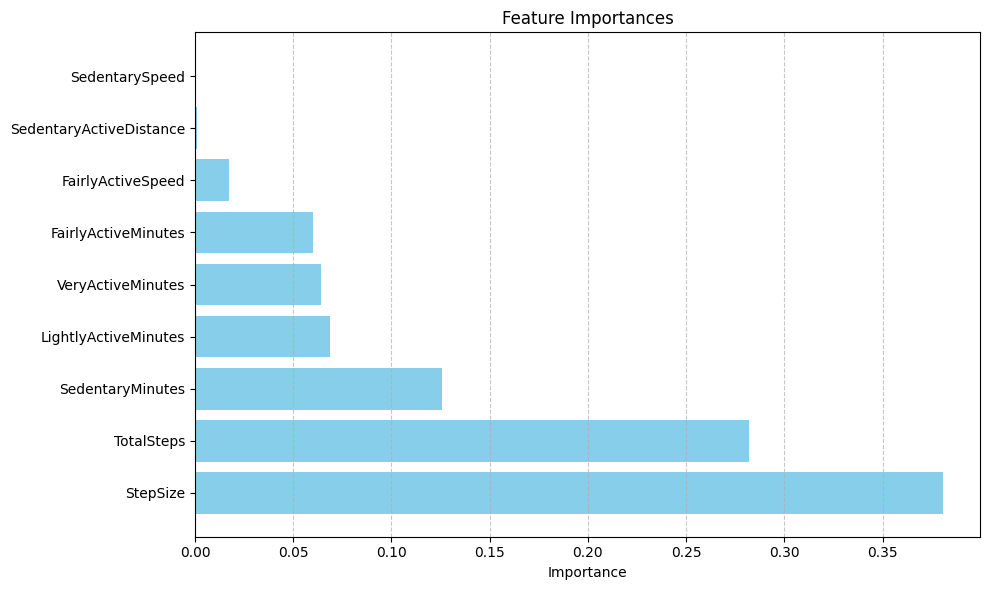

In [218]:
importances = filtered_forest_7.feature_importances_
feature_names = filtered_data_array_regressor_7["X"].columns
print(importances)
# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## GridSearchCV

In [198]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': list(range(1, 30, 5)),
    'max_depth': [None] + list(range(1, 30, 5)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': list(range(1, 11, 3)),
    'min_samples_leaf': list(range(1, 6))
}

# Create the base model
rf = RandomForestRegressor(random_state=42)

# Grid Search (or use RandomizedSearchCV for faster but random sampling)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=2)

grid_search.fit(filtered_data_array_regressor_7["X_train"], filtered_data_array_regressor_7["y_train"])

print("Best parameters found:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.scoring)


Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=1; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=6; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimators=6; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=1, n_estimat

/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6300 fits failed out of a total of 12600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_param

In [206]:
print(grid_search.cv_results_['mean_test_score'])

[       nan        nan        nan ... 0.64198173 0.63897242 0.64676057]


In [211]:
filtered_forest_6 = randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_6, kwargs={'n_estimators': 21, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False})["Model"]

In [212]:
prettyPrint(randomForestRegressor(regressor=RandomForestRegressor, **filtered_data_array_regressor_7, kwargs={'n_estimators': 21, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}))

            Model: 		RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_leaf=3,
                      min_samples_split=13, n_estimators=21)
            R2 Score: 		0.7796744942775161
            CV R2 Score: 	0.5164827719950459
            MAE: 		292.0807981497466
            RMSE: 		392.4191557774816


## RandomSearchCV

In [209]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': list(range(1, 30, 5)),
    'max_depth': [None] + list(range(1, 30, 5)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': list(range(1, 11, 3)),
    'min_samples_leaf': list(range(1, 6)),
    'bootstrap': [True, False]
}

# Create the base model
rf = RandomForestRegressor(random_state=42)

# Grid Search (or use RandomizedSearchCV for faster but random sampling)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter combinations to try
    scoring='r2',              # Use R² as scoring metric
    cv=5,                      # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                  # Use all processors
)                          

random_search.fit(filtered_data_array_regressor_7["X_train"], filtered_data_array_regressor_7["y_train"])

print("Best parameters found:", random_search.best_params_)
print("Best CV R² Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=21; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=21; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=21; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=21; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=21; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=11; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=11; total t

/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
140 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anshumaan/Development/college/health-predictor/health-predictor-venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
 

In [ ]:
filtered_forest_3 = randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=50, maxDepth=None, randomState=randomState)[0]

In [ ]:
prettyPrint(randomForestRegressor(*filtered_data_array_regressor_3, nEstimators=120, maxDepth=9, randomState=randomState, kwargs={'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}))

Model: 				RandomForestRegressor(bootstrap=False, max_depth=9, max_features='log2',
                      min_samples_split=5, n_estimators=120, random_state=42)
R2 Score: 			0.8121236970792969
CV R2 Score(Full Data): 	0.47283072566611317
CV R2 Score(CV Data): 		-0.009702082856178684
MSE: 				0.34301022770725137
RMSE: 				0.42474544487861354
